# Week 3 - Predicting Default Probability

This notebook carries out the following steps
  1.  Reads the original data including all the fields added by Lending Club to predict default probability
  2. Redo the prediction using only the fields available in our saved pickle file
  3. Start with predicting default using only signals such as the grade or interest assigned to a loan by Lending Club
  4. Redo the analysis only with variables available at the time of loan application (You can try to add more computationally intensive classifiers to the analysis below, such as random forest, bagged trees and multi-layer perceptrons)
  5. (Think about how you might choose one of these classifiers for downstream analysis of picking out the best loans to invest in. Will you use a batch, rank-ordered or customized assessment method to pick between these models? How much do you care about the interpretability of the chosen model in this decision?)
  5. (You may want to compare the default probabilities predicted from Step 4 above with the grades assigned by Lending Club to see if they capture the same signal as your models)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install scikit-plot

In [ ]:
## Change these variables when running the notebook from a new location
# data_dir should be the directory of the zip files
# pickle_input should be the location of the 201516_ret.pickle file

root_dir = "/content/drive/My Drive/BVIA Group 4/"
data_dir = root_dir + "Data/"
pickle_input = root_dir + "Pickle/201516_ret.pickle"

## Step 1 - Load the raw data again and predict default from all available fields

In [ ]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import time
import seaborn as sns
import os
import random

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix


# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Step 1-1: Computing Misclassification Costs (To be used on custom assessment later)

Cost matrix is explained in more detail in this week's report.

In [ ]:
### Read the data and features from the pickle
final_data, discrete_features, continuous_features, ret_cols = pickle.load( open(pickle_input, "rb" ) )
#final_data[ret_cols].head()


### Average Cost of False Positive (Predict Not Default, but Default in reality)
### Cost of Losing Money = average returns from default loans
avg_ret_default = final_data[final_data['loan_status'] != 'Fully Paid']['ret_Hybrid'].mean()
print(avg_ret_default)
### Average Cost of False Negative (Predict Default, but not Default in reality) 
### Opportunity Cost = Difference between returns from investing in loans and safe assets
avg_ret_nondefault = final_data[final_data['loan_status'] == 'Fully Paid']['ret_Hybrid'].mean()
print(avg_ret_nondefault)
### Return a cost matrix
FN_Cost = round(avg_ret_default,3)
TP_Gain = 0.03 #return from safe investment
TN_Gain = round(avg_ret_nondefault,3)
FP_Cost = round(0,3)
confusion_cost = np.array([[TP_Gain,FN_Cost],[FP_Cost,TN_Gain]])
print(confusion_cost)

-0.050146655802039516
0.09181748028058873
[[ 0.03  -0.05 ]
 [ 0.     0.092]]


### Read downloaded file(s) again

In [ ]:
## If you are re-running the script again and want to load all the models you have computed already and stored
# reload them from a saved dill file by uncommenting the next two lines and using the appropriate dill file name
# import dill
# dill.load_session('week3.pkl')

In [ ]:
# load the data from the file - we are loading 2015 and 2016 data
# directory = '../200711Data/'
directory = data_dir
all_files = os.listdir(directory)
output = {}
for i in all_files:
    print("    Reading file " + i)
    output[i] = pd.read_csv(directory + i, dtype = str, skiprows = 1)

    Reading file LoanStats_securev1_2016Q1.csv.zip
    Reading file LoanStats_securev1_2016Q2.csv.zip
    Reading file LoanStats3d_securev1.csv.zip
    Reading file LoanStats_securev1_2016Q3.csv.zip
    Reading file LoanStats_securev1_2016Q4.csv.zip


In [ ]:
data = pd.concat([output[i] for i in output.keys()], join='inner')

data = data[['id','loan_amnt','funded_amnt','funded_amnt_inv','term','int_rate',
         'installment','grade','sub_grade','emp_title','emp_length',
         'home_ownership','annual_inc','verification_status','issue_d',
         'loan_status','purpose','title','zip_code','addr_state','dti','total_pymnt',
         'delinq_2yrs','earliest_cr_line','open_acc','pub_rec','last_pymnt_d',
         'last_pymnt_amnt','fico_range_high','fico_range_low','last_fico_range_high',
         'last_fico_range_low','application_type','revol_bal','revol_util','recoveries']]

data.dropna(subset=['annual_inc','loan_status','issue_d','last_pymnt_d','loan_amnt',
                    'int_rate','earliest_cr_line','open_acc','pub_rec','delinq_2yrs','recoveries',
                    'grade','fico_range_high','fico_range_low','installment', 'last_fico_range_high',
                    'last_fico_range_low','funded_amnt','dti','funded_amnt_inv','revol_bal','revol_util']
            ,inplace=True)
data.shape 

(854201, 36)

In [ ]:
data.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,zip_code,addr_state,dti,total_pymnt,delinq_2yrs,earliest_cr_line,open_acc,pub_rec,last_pymnt_d,last_pymnt_amnt,fico_range_high,fico_range_low,last_fico_range_high,last_fico_range_low,application_type,revol_bal,revol_util,recoveries
0,73438990,12500,12500,12500,60 months,7.39%,249.83,A,A4,Stylist,10+ years,RENT,85000,Not Verified,Mar-2016,Charged Off,credit_card,Credit card refinancing,782xx,TX,19.6,8234.13,1,Oct-2001,19,0,Jan-2019,249.83,699,695,779,775,Individual,5346,10.5%,0.0
1,74694337,40000,40000,40000,60 months,7.89%,808.96,A,A5,CM2,< 1 year,MORTGAGE,80500,Verified,Mar-2016,Fully Paid,home_improvement,Home improvement,301xx,GA,3.74,48284.8011378833,0,Nov-1992,7,0,Jul-2020,7871.87,714,710,634,630,Individual,414,2.5%,0.0
2,74826201,7200,7200,7200,36 months,5.32%,216.83,A,A1,Mechanic,10+ years,MORTGAGE,49000,Source Verified,Mar-2016,Fully Paid,debt_consolidation,Debt consolidation,554xx,MN,19.05,7223.41,0,Dec-2001,11,0,Apr-2016,7227.67,754,750,754,750,Individual,9309,18.4%,0.0
3,74884818,32000,32000,32000,36 months,6.97%,987.63,A,A3,owner,10+ years,OWN,156000,Verified,Mar-2016,Fully Paid,home_improvement,Home improvement,164xx,PA,5.25,35337.4210393186,0,Jul-1983,5,0,Jul-2018,9677.63,699,695,819,815,Individual,3611,23.6%,0.0
4,75174813,16000,16000,16000,36 months,12.99%,539.03,C,C2,Director of Marketing,< 1 year,RENT,50000,Not Verified,Mar-2016,Charged Off,debt_consolidation,Debt consolidation,261xx,WV,38.32,5916.18,0,Aug-2000,12,0,Dec-2016,539.03,679,675,499,0,Individual,7996,51.6%,1627.03


In [ ]:
data = data[data.loan_status.isin(['Fully Paid','Charged Off','Default'])] #select only those statuses which are in scope
data.reset_index(drop=True, inplace=True)

TCount = len(data)
print("Total count: %d" %(TCount))

FCount_Orig = data.loan_status.str.contains('Fully Paid').sum()
print("Fully Paid count: %d" %(FCount_Orig))

CCount = data.loan_status.str.contains('Charged Off').sum()
print("Charged off count: %d" %(CCount))

DCount = data.loan_status.str.contains('Default').sum()
print("Default count: %d" %(DCount))

DProp = 1-(FCount_Orig/TCount)
print("Proportion of Charged off + Default: %.2f" %(DProp))

print("\nNull stats:")
print(data.isna().sum())

Total count: 815879
Fully Paid count: 657121
Charged off count: 158719
Default count: 39
Proportion of Charged off + Default: 0.19

Null stats:
id                          0
loan_amnt                   0
funded_amnt                 0
funded_amnt_inv             0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               50382
emp_length              50072
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                   21521
zip_code                    0
addr_state                  0
dti                         0
total_pymnt                 0
delinq_2yrs                 0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
last_pymnt_d                0
last_pymnt_amnt             0
fico_range_high 

In [ ]:
## Downsample the fully paid loans
indexNames = data[data['loan_status'] == "Fully Paid" ].index #pull indexes of fully paid rows
delRowCount = int(0.5*FCount_Orig) 
random.seed(4)
data=data.drop(random.sample(set(indexNames), delRowCount)) #remove ~50% of the 'fully paid' entries

TCount = len(data)
print("Total count: %d" %(TCount))

FCount = data.loan_status.str.contains('Fully Paid').sum()
print("Fully Paid count: %d" %(FCount))

CCount = data.loan_status.str.contains('Charged Off').sum()
print("Charged off count: %d" %(CCount))

DCount = data.loan_status.str.contains('Default').sum()
print("Default count: %d" %(DCount))

DProp = 1-(FCount/TCount)
print("Proportion of Charged off + Default: %.2f" %(DProp))

Total count: 487319
Fully Paid count: 328561
Charged off count: 158719
Default count: 39
Proportion of Charged off + Default: 0.33


In [ ]:
# Identify the type of each of these column
float_cols = ['loan_amnt', 'funded_amnt', 'installment', 'annual_inc',
            'dti', 'revol_bal', 'delinq_2yrs', 'open_acc', 'pub_rec',
                'fico_range_high', 'fico_range_low','last_fico_range_low',
              'last_fico_range_high','total_pymnt', 'recoveries']
cat_cols = ['term', 'grade', 'emp_length', 'home_ownership',
                    'verification_status', 'loan_status', 'purpose']
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

for j in float_cols:
    data[j] = pd.to_numeric(data[j])
    
for j in perc_cols:
    data[j] = data[j].str.strip('%')
    data[j] = pd.to_numeric(data[j])
    data[j] = data[j]/100

for j in date_cols:
    data[j] = pd.to_datetime(data[j])

### Engineer the features and generate the training/testing set

In [ ]:
default_seed = 1
np.random.seed(default_seed)

# select only terminated loans
data = data[data.loan_status.isin(['Fully Paid','Charged Off','Default'])]

# downsample
data = data.sample(n=5000)

# create labels for the dataset
data['label'] = (data.loan_status.str.contains('Charged Off') | 
                data.loan_status.str.contains('Default'))
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
data.label = data.label.astype(int)



# clean and get training/testing data 
temp = pd.get_dummies(data[['term','grade','emp_length','home_ownership',
                                  'verification_status','purpose']],dummy_na=True)
subdata = data[['loan_amnt','funded_amnt','int_rate','installment',                            
                'annual_inc','dti','delinq_2yrs','open_acc','pub_rec',
                            'fico_range_high','fico_range_low','cr_hist','revol_bal',
                            'recoveries','last_fico_range_high','last_fico_range_low',
                            'revol_util', 'total_pymnt']]
X = subdata.to_numpy()
#X = data.as_matrix(columns=['loan_amnt','funded_amnt','int_rate','installment',
#                            'annual_inc','dti','delinq_2yrs','open_acc','pub_rec',
#                            'fico_range_high','fico_range_low','cr_hist','revol_bal',
#                            'recoveries','last_fico_range_high','last_fico_range_low',
#                            'revol_util', 'total_pymnt'])

#X = np.concatenate((X,temp.as_matrix()),axis=1)
X = np.concatenate((X,temp.to_numpy()),axis=1)

#y = data.label.as_matrix()
y = data.label.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(3500, 63)
(1500, 63)


In [ ]:
TCount = len(data)
print("Total count: %d" %(TCount))

FCount = data.loan_status.str.contains('Fully Paid').sum()
print("Fully Paid count: %d" %(FCount))

CCount = data.loan_status.str.contains('Charged Off').sum()
print("Charged off count: %d" %(CCount))

DCount = data.loan_status.str.contains('Default').sum()
print("Default count: %d" %(DCount))

print("Proportion of Charged off + Default: %.2f" %(1-(FCount/TCount)))

Total count: 5000
Fully Paid count: 3371
Charged off count: 1629
Default count: 0
Proportion of Charged off + Default: 0.33


## Classification models

### $l_2$ penalized logistic regression

In [ ]:
logisticModel = LogisticRegressionCV(cv=10,penalty='l2',max_iter=2000)
logisticModel.fit(X_train,y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=2000, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [ ]:
y_pred = logisticModel.predict(X_test)
print('accuracy: ',accuracy_score(y_test,y_pred))
target_names = ['Non-Defaulted Loan','Defaulted Loan']
print(classification_report(y_test,y_pred,target_names=target_names,digits=4))
print('AUC: ',roc_auc_score(y_test,logisticModel.predict_proba(X_test)[:,1]))

accuracy:  0.976
                    precision    recall  f1-score   support

Non-Defaulted Loan     0.9805    0.9843    0.9824      1022
    Defaulted Loan     0.9662    0.9582    0.9622       478

          accuracy                         0.9760      1500
         macro avg     0.9734    0.9713    0.9723      1500
      weighted avg     0.9760    0.9760    0.9760      1500

AUC:  0.9956132450114223


In [ ]:
confusion_matrix(y_test, y_pred)

array([[1006,   16],
       [  20,  458]])

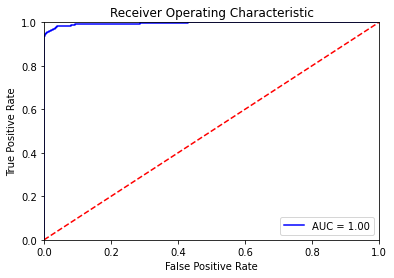

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, logisticModel.predict_proba(X_test)[:,1],
                                         pos_label=1)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% roc_auc_score(y_test,logisticModel.predict_proba(X_test)[:,1]))
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

*To understand the astonishing result above, examine the most significant features in this model to see what is giving it the very strong predicitve power.*

Below, we examine the Odds Ratio Change for each of the Logistic Regression coefficients. Below 100% means that the variable negatively affects the Odds Ratio (lowers the probability of default). Over 100% means the opposite - higher probability of default.

In [ ]:
np.exp(logisticModel.coef_)
logisticCols = list(subdata.columns) + list(temp.columns)
logisticStd = np.std(X_train, axis=0)
logisticResultDf = pd.DataFrame()
logisticResultDf['Column'] = logisticCols
logisticResultDf['Coef'] = (logisticModel.coef_).reshape(-1,1)
logisticResultDf['StdDev'] = logisticStd

In [ ]:
logisticResultDf['OddsChange'] = logisticResultDf.apply(lambda x: np.exp(x['Coef'] * x['StdDev']), axis=1)

In [ ]:
logisticResultDf.sort_values(by='OddsChange').style.format({"OddsChange":"{:.2%}"})

,Column,Coef,StdDev,OddsChange
17,total_pymnt,-111.229717,0.167921,0.00%
14,last_fico_range_high,-12.235650,0.250787,4.65%
18,term_ 36 months,-1.781365,0.451074,44.77%
2,int_rate,-3.269199,0.187372,54.20%
21,grade_A,-1.434964,0.362584,59.43%
50,purpose_car,-5.989525,0.080798,61.64%
57,purpose_moving,-6.442478,0.071529,63.08%
4,annual_inc,-8.153260,0.053531,64.63%
32,emp_length_3 years,-1.675427,0.259902,64.70%
39,emp_length_< 1 year,-1.387611,0.278243,67.97%


### Random forest
*In addition to logistic regression, you can also take a quick look at random forest or any other classification models you like.*

In [ ]:
random_forest = RandomForestClassifier(min_samples_leaf=100,n_estimators=50)
random_forest.fit(X_train,y_train)
y_pred = random_forest.predict(X_test)
print('accuracy: ',accuracy_score(y_test,y_pred))
target_names = ['Non-Defaulted Loan','Defaulted Loan']
print(classification_report(y_test,y_pred,target_names=target_names,digits=4))
print('AUC: ',roc_auc_score(y_test,random_forest.predict_proba(X_test)[:,1]))

accuracy:  0.9526666666666667
                    precision    recall  f1-score   support

Non-Defaulted Loan     0.9482    0.9843    0.9659      1022
    Defaulted Loan     0.9636    0.8849    0.9226       478

          accuracy                         0.9527      1500
         macro avg     0.9559    0.9346    0.9442      1500
      weighted avg     0.9531    0.9527    0.9521      1500

AUC:  0.9884261723259831


Below is the Feature Importance of the Random Forest classifier.

In [ ]:
rfResultDf = pd.DataFrame()
rfResultDf['Column'] = logisticCols
rfResultDf['FeatureImportance'] = random_forest.feature_importances_.reshape(-1,1)
rfResultDf.sort_values(by="FeatureImportance",ascending=False).head(15)

,Column,FeatureImportance
13,recoveries,0.322659
14,last_fico_range_high,0.287823
15,last_fico_range_low,0.194529
17,total_pymnt,0.067367
2,int_rate,0.034541
18,term_ 36 months,0.019779
21,grade_A,0.012437
0,loan_amnt,0.009461
9,fico_range_high,0.008005
19,term_ 60 months,0.007005


# Step 2 - Redo predictions with the columns stored in our pickle file

In [ ]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score, confusion_matrix

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
## from gurobipy import *
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
#from scipy.interpolate import spline

import scikitplot as skplt

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)

    all_perc_diff = []

    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass

    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass

    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False

    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break

    return out

## Define a default random seed and an output file

In [ ]:
default_seed = 1
output_file = "output_sample_ravi"

In [ ]:
# Create a function to print a line to our output file

def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## Load the data and engineer the features

In [ ]:
# Read the data and features from the pickle
data, discrete_features, continuous_features, ret_cols = pickle.load( open( pickle_input, "rb" ) )

Let's look at the spread of loan statuses

In [ ]:
data = data[data.loan_status.isin(['Fully Paid','Charged Off','Default'])] #select only those statuses which are in scope
data.reset_index(drop=True, inplace=True)

TCount = len(data)
print("Total count: %d" %(TCount))

FCount_Orig = data.loan_status.str.contains('Fully Paid').sum()
print("Fully Paid count: %d" %(FCount_Orig))

CCount = data.loan_status.str.contains('Charged Off').sum()
print("Charged off count: %d" %(CCount))

DCount = data.loan_status.str.contains('Default').sum()
print("Default count: %d" %(DCount))

DProp = 1-(FCount_Orig/TCount)
print("Proportion of Charged off + Default: %.2f" %(DProp))

print("\nNull stats:")
print(data.isna().sum())

Total count: 810845
Fully Paid count: 652384
Charged off count: 158423
Default count: 38
Proportion of Charged off + Default: 0.20

Null stats:
id                              0
loan_amnt                       0
funded_amnt                     0
term                            0
int_rate                        0
installment                     0
grade                           0
emp_length                  49637
home_ownership                  0
annual_inc                      0
verification_status             0
issue_d                         0
loan_status                     0
purpose                         0
dti                             0
delinq_2yrs                     0
earliest_cr_line                0
open_acc                        0
pub_rec                         0
fico_range_high                 0
fico_range_low                  0
revol_bal                       0
revol_util                      0
total_pymnt                     0
last_pymnt_d                    0
recove

Downsample the fully paid loans so that target classes align

In [ ]:
indexNames = data[data['loan_status'] == "Fully Paid" ].index #pull indexes of fully paid rows
delRowCount = int(0.7*FCount_Orig) 
random.seed(4)
data=data.drop(random.sample(set(indexNames), delRowCount)) #remove ~70% of the 'fully paid' entries

TCount = len(data)
print("Total count: %d" %(TCount))

FCount = data.loan_status.str.contains('Fully Paid').sum()
print("Fully Paid count: %d" %(FCount))

CCount = data.loan_status.str.contains('Charged Off').sum()
print("Charged off count: %d" %(CCount))

DCount = data.loan_status.str.contains('Default').sum()
print("Default count: %d" %(DCount))

DProp = 1-(FCount/TCount)
print("Proportion of Charged off + Default: %.2f" %(DProp))

Total count: 354177
Fully Paid count: 195716
Charged off count: 158423
Default count: 38
Proportion of Charged off + Default: 0.45


In [ ]:
discrete_features

['purpose',
 'term',
 'verification_status',
 'grade',
 'emp_length',
 'home_ownership']

In [ ]:
continuous_features

['loan_amnt',
 'funded_amnt',
 'installment',
 'annual_inc',
 'dti',
 'revol_bal',
 'delinq_2yrs',
 'open_acc',
 'pub_rec',
 'fico_range_high',
 'fico_range_low',
 'int_rate',
 'revol_util']

In [ ]:
data.shape

(354177, 59)

In [ ]:
# Create the outcome
data["outcome"] = data.loan_status.isin(["Charged Off", "Default"])

In [ ]:
# Create a feature for the length of a person's credit history at the
# time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [ ]:
# Randomly assign each row to a training and test set. We do this now
# because we will be fitting a variety of models on various time periods,
# and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
data['train'] = np.random.choice([True, False], size = len(data), p = [0.7, 0.3])

In [ ]:
# Create a matrix of features and outcomes, with dummies. Record the
# names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

In [ ]:
continuous_features

['loan_amnt',
 'funded_amnt',
 'installment',
 'annual_inc',
 'dti',
 'revol_bal',
 'delinq_2yrs',
 'open_acc',
 'pub_rec',
 'fico_range_high',
 'fico_range_low',
 'int_rate',
 'revol_util',
 'cr_hist']

In [ ]:
discrete_features_dummies

['purpose::credit_card',
 'purpose::debt_consolidation',
 'purpose::home_improvement',
 'purpose::house',
 'purpose::major_purchase',
 'purpose::medical',
 'purpose::moving',
 'purpose::other',
 'purpose::renewable_energy',
 'purpose::small_business',
 'purpose::vacation',
 'purpose::wedding',
 'purpose::nan',
 'term:: 60 months',
 'term::nan',
 'verification_status::Source Verified',
 'verification_status::Verified',
 'verification_status::nan',
 'grade::B',
 'grade::C',
 'grade::D',
 'grade::E',
 'grade::F',
 'grade::G',
 'grade::nan',
 'emp_length::10+ years',
 'emp_length::2 years',
 'emp_length::3 years',
 'emp_length::4 years',
 'emp_length::5 years',
 'emp_length::6 years',
 'emp_length::7 years',
 'emp_length::8 years',
 'emp_length::9 years',
 'emp_length::< 1 year',
 'emp_length::nan',
 'home_ownership::MORTGAGE',
 'home_ownership::OWN',
 'home_ownership::RENT',
 'home_ownership::nan']

In [ ]:
X.shape

(354177, 54)

## Prepare functions to fit and evaluate models

Note we made some significant additions to the fit_classification function below.

In [ ]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 25000,
                    n_samples_test = 10000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows

    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.

    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''

    np.random.seed(random_state)

    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values

    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                   - n_samples_test, replace = False ) ] = False

    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        # print(cols)
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]

    y_train = y[ filter_train ]
    y_test = y[ filter_test ]

    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train,
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}

    return out

In [ ]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True,
                          output_confusion_matrix = False,
                            predProb=False,
                          show_plots=False):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
      * Added the below parameters *
      - output_confusion_matrix: if a confusion matrix and custom cost metric will be printed to the screen
        and returned as an output of the function
      - predProb: return predicted probabilities as an output, for convenience
      - show_plots: show scatter plot of important features against prediction (only use for Part 4)

    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.

    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.

    * Added * We also print the Gain and Lift charts and decile lift tables.

    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not
                      output probabilities.
    '''

    np.random.seed(random_state)

    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']

    X_test = data_dict['X_test']
    y_test = data_dict['y_test']

    filter_train = data_dict['train_set']

    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)

    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()

    best_model = cv_model.best_estimator_

    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")

    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------

    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        y_pred_proba = best_model.predict_proba(X_test) # Need prob of both classes for gain/lift
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

        probs_predicted = True
    except:
        probs_predicted = False

    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)

        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()

        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]

        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))

        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)

    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if output_confusion_matrix:
        tp, fn, fp, tn = confusion_matrix(y_test,y_pred, labels=[True,False]).reshape(-1)
        matrix = np.array([[tp,fn],[fp,tn]])
        print('Confusion matrix : \n',matrix)

        TP_Gain = 0.03 #return from safe investment
        FN_Cost = -0.05
        FP_Cost = 0 
        TN_Gain = 0.092
        confusion_cost = np.array([[TP_Gain,FN_Cost],[FP_Cost,TN_Gain]])
        expectedValue = np.sum(matrix * confusion_cost)
        print("Expected Value: %.2f" %(expectedValue))


    if print_to_screen:
        if probs_predicted:
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')

            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')

            #plt.tight_layout()
            plt.show()

    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)

    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)

    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)

    # Lift and gain metrics
    # ---------------------
    if probs_predicted:
        skplt.metrics.plot_cumulative_gain(y_test, y_pred_proba)
        plt.show()

        skplt.metrics.plot_lift_curve(y_test, y_pred_proba)
        plt.show()

    if probs_predicted:
      lift_scores = y_pred_probs
    # else:
    #   lift_scores = y_pred_score
      liftDF = pd.DataFrame()
      liftDF["Score"] = lift_scores
      liftDF["Default"] = y_test
      liftDF['Decile'] = pd.qcut(liftDF['Score'].rank(method='first'),10,labels=range(10,0,-1),duplicates='drop')

      total_pred_positive = sum(y_test)
      qtile_pred_positive = sum(y_test)/max(liftDF['Decile'])

      liftDF = pd.pivot_table(data=liftDF,index=['Decile'],values=['Default','Score'],
                      aggfunc={'Default':[np.sum],
                                'Score' : [np.min,np.max]})
      liftDF.reset_index(inplace=True)
      liftDF.columns = ['Decile','Default Count','max_score','min_score']
      liftDF.sort_values(by='min_score',ascending=False, inplace=True)

      liftDF["Decile Amount"] = qtile_pred_positive
      liftDF["Cumulative Decile Amt"] = liftDF["Decile Amount"].cumsum()
      liftDF["Cumulative Default Amt"] = liftDF["Default Count"].cumsum()
      liftDF["Decile Lift"] = liftDF["Cumulative Default Amt"]/liftDF["Cumulative Decile Amt"]
      print(liftDF[["Decile","Decile Lift"]])

    #scatter plot of y_preds and test data (important variables)
    if probs_predicted and show_plots==True:
      plt.subplot(2, 3, 1)
      plt.scatter(y_pred_probs[:,], X_test[:,3]) #dti
      plt.xlabel('Default Probability') 
      plt.ylabel('dti')

      plt.subplot(2, 3, 2)
      plt.scatter(y_pred_probs[:,], X_test[:,8]) #fico_Score high
      plt.xlabel('Default Probability') 
      plt.ylabel('fico score high')

      plt.subplot(2, 3, 3)
      plt.scatter(y_pred_probs[:,], X_test[:,25]) #term_60 months
      plt.xlabel('Default Probability') 
      plt.ylabel('term_60 months')

      plt.subplot(2, 3, 4)
      plt.scatter(y_pred_probs[:,], X_test[:,4]) #revol_bal
      plt.xlabel('Default Probability') 
      plt.ylabel('revol_bal')

      plt.subplot(2, 3, 5)
      plt.scatter(y_pred_probs[:,], X_test[:,6]) #open_acc
      plt.xlabel('Default Probability') 
      plt.ylabel('open_acc')
      
      plt.tight_layout()
      plt.show()

    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}

    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})

    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))

        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))

        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )

        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )

    if predProb and output_confusion_matrix:
      return out, y_pred_probs
    elif output_confusion_matrix:
      return out, matrix
    else:
      return out


## Run classification models on all features in pickle


In [ ]:
final_features = discrete_features + continuous_features
data_dict = prepare_data(feature_subset = final_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in final_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

data_dict = prepare_data(feature_subset=continuous_features+discrete_features)

### $l_1$ penalized logistic regression

(Takes a long time to run)

In [ ]:
# pickle_logistic_l1 = LogisticRegression(penalty = 'l1', solver='liblinear')
# cv_parameters = {"C":np.logspace(0, 50, num = 20)}

# pickle_logistic_l1 = fit_classification(pickle_logistic_l1, data_dict,
#                         cv_parameters = cv_parameters, model_name = "Pickle logistic l1")

### $l_2$ penalized logistic regression

  Model: Pickle logistic l2
Fit time: 2.8 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.5002666017900825
Accuracy:  0.65
              precision    recall  f1-score   support

  No default     0.6680    0.7224    0.6941      5497
     Default     0.6237    0.5616    0.5910      4503

    accuracy                         0.6500     10000
   macro avg     0.6458    0.6420    0.6426     10000
weighted avg     0.6480    0.6500    0.6477     10000



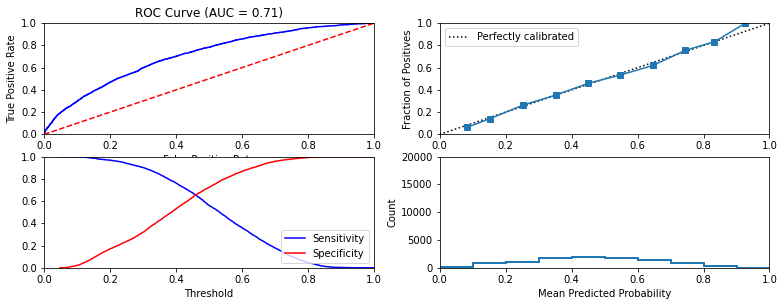


Similarity to LC grade ranking:  0.7451256278139421
Brier score: 0.21427817459949233


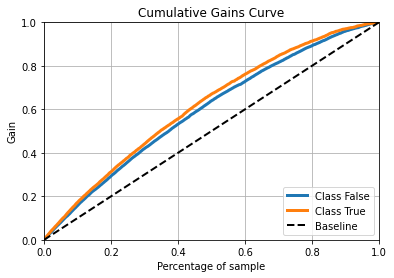

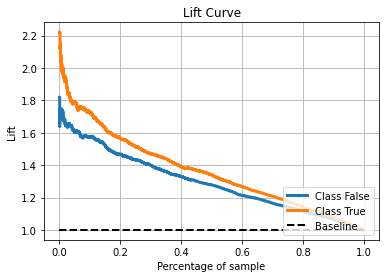

  Decile  Decile Lift
9      1     1.723296
8      2     1.564513
7      3     1.470131
6      4     1.390184
5      5     1.339551
4      6     1.268044
3      7     1.208718
2      8     1.142294
1      9     1.077553
0     10     1.000000
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.65372]


In [ ]:
pickle_logistic_l2 = LogisticRegression(penalty = 'l2', solver='lbfgs')
cv_parameters = {"C":np.logspace(0, 50, num = 20)}

pickle_logistic_l2 = fit_classification(pickle_logistic_l2, data_dict, model_name = 'Pickle logistic l2')

### Naive Bayes

  Model: All Feature Gaussian Naive Bayes
Fit time: 0.19 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.1636634051996386
Accuracy:  0.6425
              precision    recall  f1-score   support

  No default     0.6535    0.7442    0.6959      5497
     Default     0.6241    0.5183    0.5663      4503

    accuracy                         0.6425     10000
   macro avg     0.6388    0.6313    0.6311     10000
weighted avg     0.6403    0.6425    0.6376     10000

Confusion matrix : 
 [[2334 2169]
 [1406 4091]]
Expected Value: 337.94


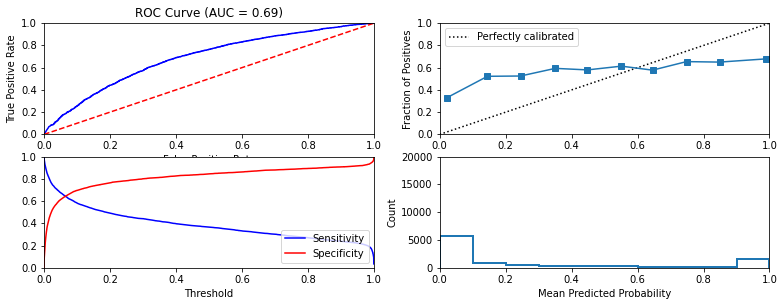


Similarity to LC grade ranking:  0.713557641228694
Brier score: 0.3119198136401377


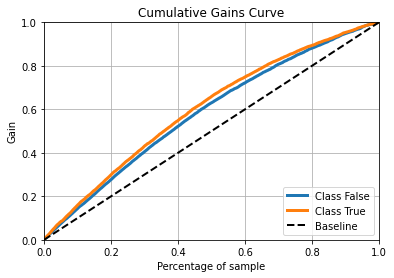

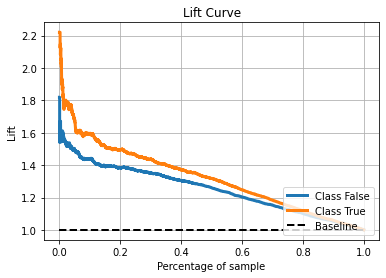

  Decile  Decile Lift
9      1     1.592272
8      2     1.495670
7      3     1.437560
6      4     1.371308
5      5     1.317788
4      6     1.248057
3      7     1.183655
2      8     1.117311
1      9     1.059047
0     10     1.000000


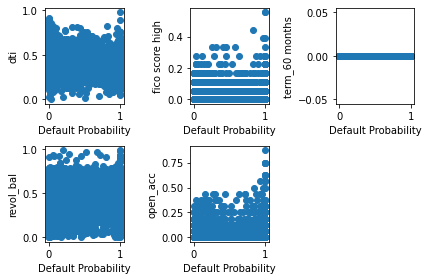

Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.6312]


In [ ]:
all_feature_gnb = GaussianNB()
all_feature_gnb = fit_classification(all_feature_gnb, data_dict,
                model_name = "All Feature Gaussian Naive Bayes",output_confusion_matrix=True)

### Random Forest

  Model: Random forest
Fit time: 55.74 seconds
Optimal parameters:
{'min_samples_leaf': 500}

Accuracy-maximizing threshold was: 0.4799654926711312
Accuracy:  0.6506
              precision    recall  f1-score   support

  No default     0.6758    0.7004    0.6879      5497
     Default     0.6172    0.5898    0.6032      4503

    accuracy                         0.6506     10000
   macro avg     0.6465    0.6451    0.6455     10000
weighted avg     0.6494    0.6506    0.6498     10000



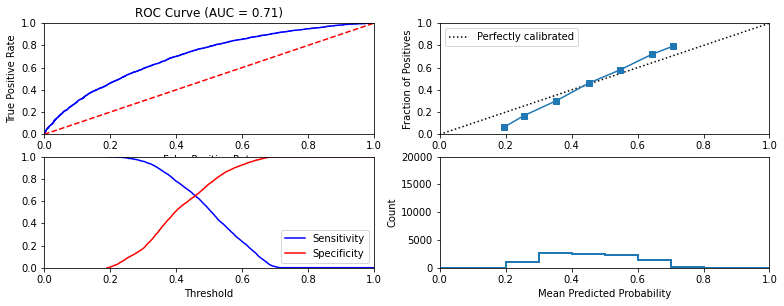


Similarity to LC grade ranking:  0.7784891484120822
Brier score: 0.2186362071974539


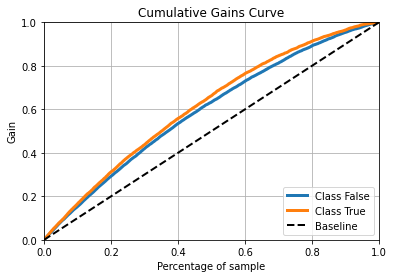

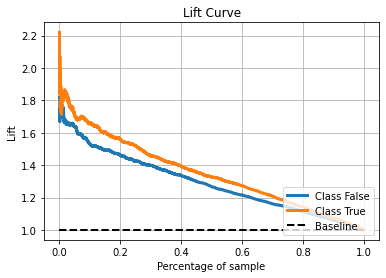

  Decile  Decile Lift
9      1     1.658894
8      2     1.560071
7      3     1.457547
6      4     1.394626
5      5     1.325339
4      6     1.273595
3      7     1.208083
2      8     1.141184
1      9     1.071878
0     10     1.000000


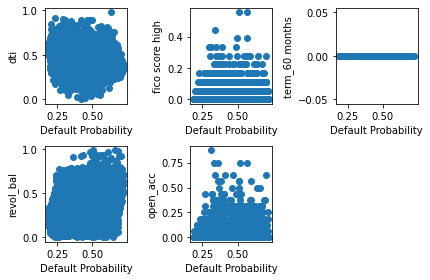

Were parameters on edge? : True
Score variations around CV search grid : 1.0718905932360125
[0.64932 0.6468  0.64728 0.64564 0.6456  0.64512 0.64336 0.64236 0.64248]


In [ ]:
random_forest = RandomForestClassifier()
cv_parameters = {'min_samples_leaf':[500,600,700,800,900,1000, 1100, 1200, 1300]}

random_forest = fit_classification(random_forest, data_dict,
                          cv_parameters = cv_parameters, model_name = "Random forest")

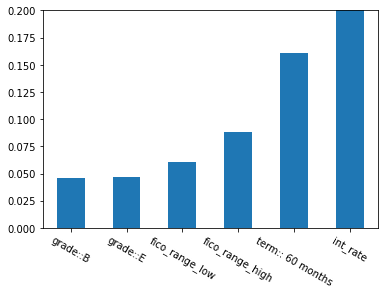

In [ ]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

### Bagged Trees

  Model: Bagged trees
Fit time: 260.0 seconds
Optimal parameters:
{'min_samples_leaf': 1000}

Accuracy-maximizing threshold was: 0.49368454030835174
Accuracy:  0.6471
              precision    recall  f1-score   support

  No default     0.6695    0.7071    0.6878      5497
     Default     0.6161    0.5738    0.5942      4503

    accuracy                         0.6471     10000
   macro avg     0.6428    0.6405    0.6410     10000
weighted avg     0.6455    0.6471    0.6457     10000



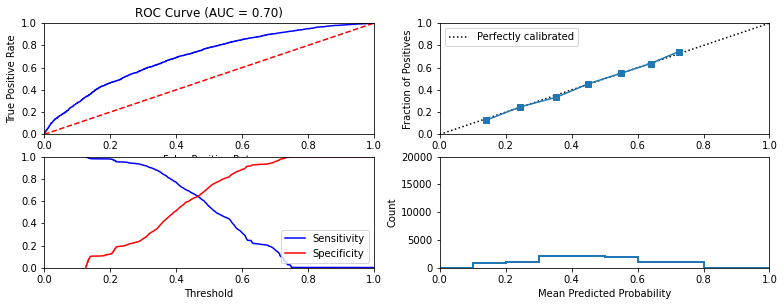


Similarity to LC grade ranking:  0.828790086307083
Brier score: 0.2175060222050345


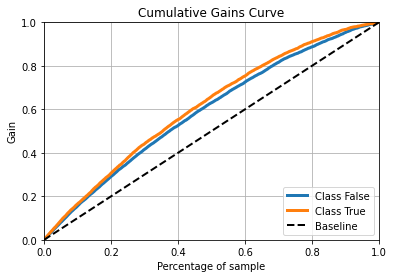

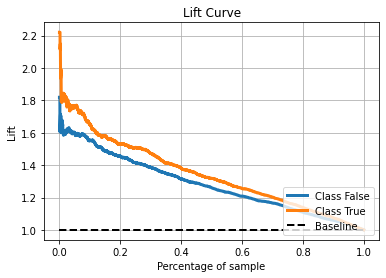

  Decile  Decile Lift
9      1     1.650011
8      2     1.531201
7      3     1.473832
6      4     1.382967
5      5     1.317788
4      6     1.254719
3      7     1.202056
2      8     1.138685
1      9     1.074839
0     10     1.000000


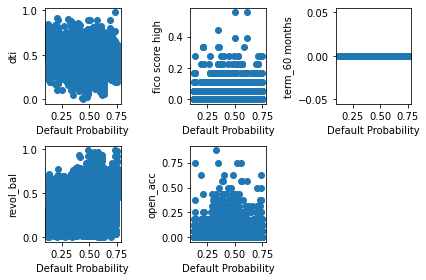

Were parameters on edge? : False
Score variations around CV search grid : 0.43265962049570805
[0.64672 0.64604 0.64512 0.6462  0.64548 0.64716 0.64608 0.64436 0.6444 ]


In [ ]:
random_forest = RandomForestClassifier(max_features = 1.0)
cv_parameters = {'min_samples_leaf':[500,600,700,800,900,1000, 1100, 1200, 1300]}

random_forest = fit_classification(random_forest, data_dict,
                          cv_parameters = cv_parameters, model_name = "Bagged trees")

### MLP

  Model: all_feature MLP
Fit time: 38.6 seconds
Optimal parameters:
{'activation': 'identity', 'solver': 'sgd'}

Accuracy-maximizing threshold was: 0.49968059865539904
Accuracy:  0.6531
              precision    recall  f1-score   support

  No default     0.6702    0.7264    0.6972      5497
     Default     0.6279    0.5636    0.5940      4503

    accuracy                         0.6531     10000
   macro avg     0.6490    0.6450    0.6456     10000
weighted avg     0.6512    0.6531    0.6507     10000

Confusion matrix : 
 [[2538 1965]
 [1504 3993]]
Expected Value: 345.25


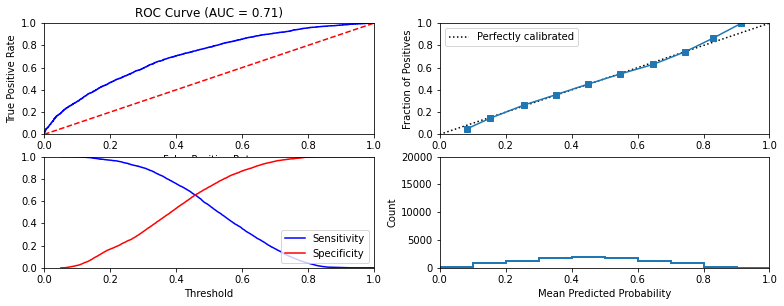


Similarity to LC grade ranking:  0.7505641375562507
Brier score: 0.21442050582503724


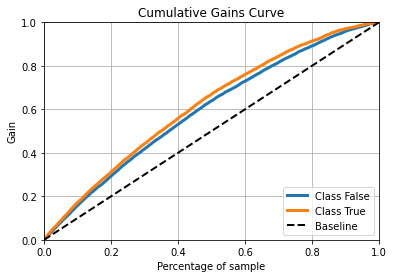

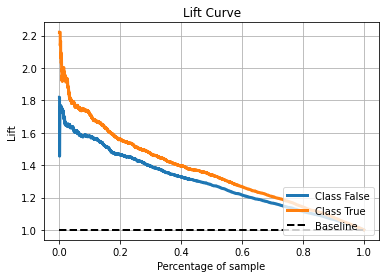

  Decile  Decile Lift
9      1     1.714413
8      2     1.560071
7      3     1.470871
6      4     1.394626
5      5     1.338219
4      6     1.266193
3      7     1.205546
2      8     1.141461
1      9     1.078293
0     10     1.000000


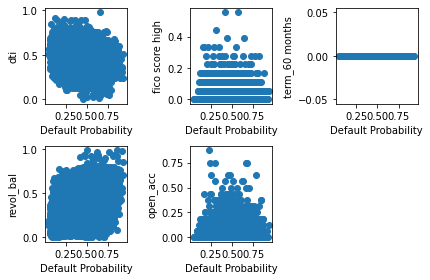

Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.65264]


In [ ]:
all_feature_MLP = MLPClassifier(random_state=1, max_iter=50,  
                         batch_size=100, hidden_layer_sizes=(100,))

all_feature_MLP, c_matrix = fit_classification(all_feature_MLP, data_dict,
                                         cv_parameters = {'solver': ['sgd'], 'activation':['identity']},
                                         model_name = 'all_feature MLP', output_confusion_matrix = True)

In [ ]:
### Return a cost matrix
TP_Gain = 0.03 #return from safe investment
FN_Cost = -0.05
FP_Cost = 0 
TN_Gain = 0.092
confusion_cost = np.array([[TP_Gain,FN_Cost],[FP_Cost,TN_Gain]])
print(confusion_cost)
expectedValue = np.sum(c_matrix * confusion_cost)
print(expectedValue)

[[ 0.03  -0.05 ]
 [ 0.     0.092]]
345.246


## Step 3 - Baseline models
See how well we do using grade or interest rate only

### Grade Only

#### $l_1$ penalized logistic regression (Grade only)

  Model: Grade only Logistic l1
Fit time: 5.82 seconds
Optimal parameters:
{'C': 1.0}

Accuracy-maximizing threshold was: 0.5895467716028465
Accuracy:  0.6044
              precision    recall  f1-score   support

  No default     0.5889    0.9289    0.7208      5497
     Default     0.7058    0.2083    0.3217      4503

    accuracy                         0.6044     10000
   macro avg     0.6473    0.5686    0.5212     10000
weighted avg     0.6415    0.6044    0.5411     10000



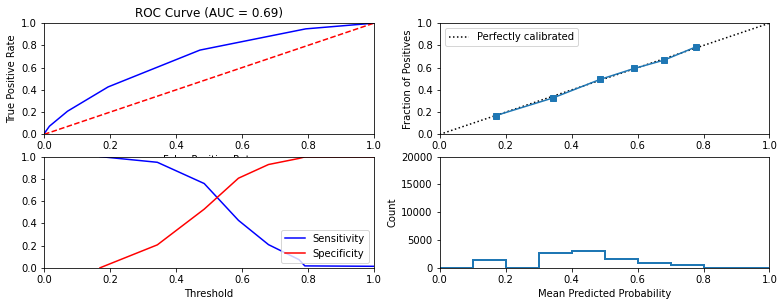


Similarity to LC grade ranking:  1.0
Brier score: 0.21984567602288513


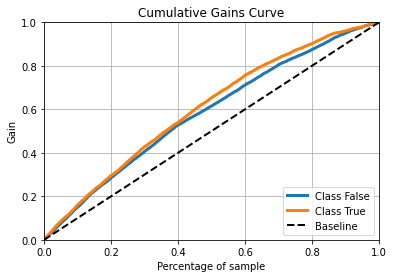

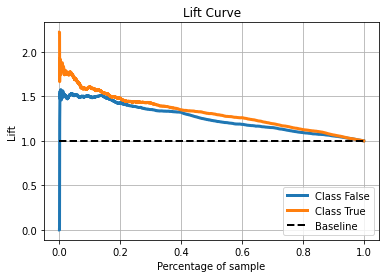

  Decile  Decile Lift
9      1     1.590051
8      2     1.490118
4      6     1.370198
5      5     1.308017
6      4     1.253831
7      3     1.261011
2      8     1.188414
3      7     1.128137
0     10     1.043749
1      9     1.000000
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.63408 0.63408 0.63408 0.63408 0.63408 0.63408 0.63408 0.63408 0.63408
 0.63408 0.63408 0.63408 0.63408 0.63408 0.63408 0.63408 0.63408 0.63408
 0.63408 0.63408]


In [ ]:
data_dict = prepare_data(feature_subset=['grade'])
grade_only_logistic_l1 = LogisticRegression(penalty = 'l1', solver='liblinear')
cv_parameters = {"C":np.logspace(0, 50, num = 20)}

grade_only_logistic_l1 = fit_classification(grade_only_logistic_l1, data_dict,
                        cv_parameters = cv_parameters, model_name = "Grade only Logistic l1")

#### $l_2$ penalized logistic regression (Grade only)

  Model: Grade only logistic l2
Fit time: 7.54 seconds
Optimal parameters:
{'C': 1.0}

Accuracy-maximizing threshold was: 0.5893230027816116
Accuracy:  0.6044
              precision    recall  f1-score   support

  No default     0.5889    0.9289    0.7208      5497
     Default     0.7058    0.2083    0.3217      4503

    accuracy                         0.6044     10000
   macro avg     0.6473    0.5686    0.5212     10000
weighted avg     0.6415    0.6044    0.5411     10000



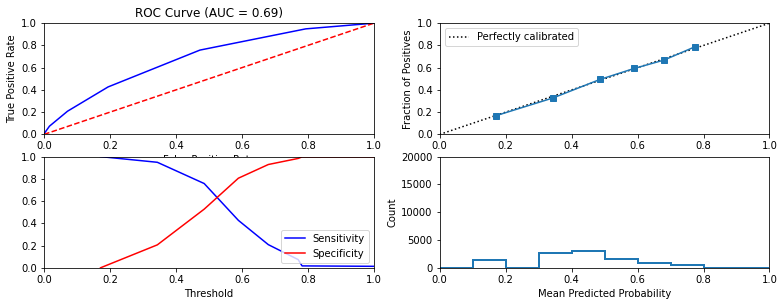


Similarity to LC grade ranking:  1.0
Brier score: 0.21985375033901372


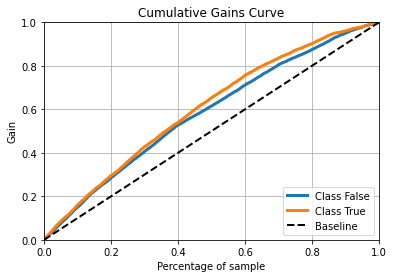

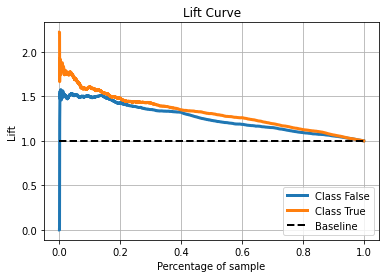

  Decile  Decile Lift
9      1     1.590051
8      2     1.490118
4      6     1.370198
5      5     1.308017
6      4     1.253831
7      3     1.261011
2      8     1.188414
3      7     1.128137
0     10     1.043749
1      9     1.000000
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.63408 0.63408 0.63408 0.63408 0.63408 0.63408 0.63408 0.63408 0.63408
 0.63408 0.63408 0.63408 0.63408 0.63408 0.63408 0.63408 0.63408 0.63408
 0.63408 0.63408]


In [ ]:
data_dict = prepare_data(feature_subset=['grade'])
grade_only_logistic = LogisticRegression(penalty = 'l2', C=np.inf, solver='lbfgs')
cv_parameters = {"C":np.logspace(0, 50, num = 20)}

grade_only_logistic = fit_classification(grade_only_logistic,data_dict,
                                         cv_parameters = cv_parameters, model_name = 'Grade only logistic l2')

  Model: Interest rate only logistics l2
Fit time: 0.24 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.45434343621149886
Accuracy:  0.6382
              precision    recall  f1-score   support

  No default     0.6632    0.6944    0.6785      5497
     Default     0.6042    0.5696    0.5864      4503

    accuracy                         0.6382     10000
   macro avg     0.6337    0.6320    0.6324     10000
weighted avg     0.6367    0.6382    0.6370     10000



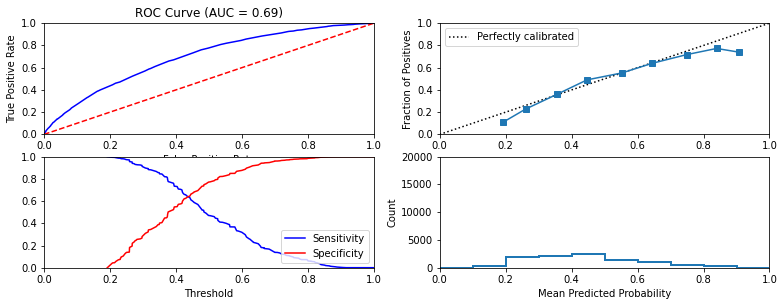


Similarity to LC grade ranking:  0.8826478717984018
Brier score: 0.22025165033821853


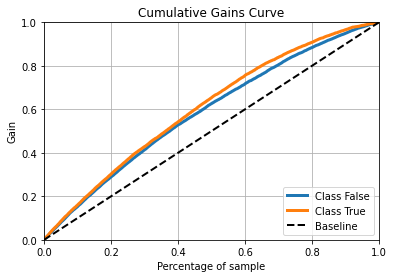

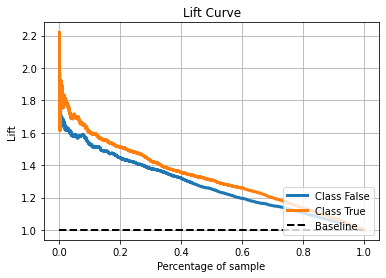

  Decile  Decile Lift
9      1     1.601155
8      2     1.513435
7      3     1.426456
6      4     1.355208
5      5     1.307129
4      6     1.259161
3      7     1.199201
2      8     1.133966
1      9     1.072618
0     10     1.000000
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.63868]


In [ ]:
data_dict = prepare_data(feature_subset=['int_rate'])
interest_only_logistic = LogisticRegression(penalty = 'l2', C=np.inf, solver='lbfgs')

interest_only_logistic = fit_classification(interest_only_logistic, data_dict,
                                   model_name = 'Interest rate only logistics l2')

#### Naive Bayes (Grade Only)

  Model: Grade Only Gaussian Naive Bayes
Fit time: 0.05 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.37810783084145694
Accuracy:  0.6044
              precision    recall  f1-score   support

  No default     0.5889    0.9289    0.7208      5497
     Default     0.7058    0.2083    0.3217      4503

    accuracy                         0.6044     10000
   macro avg     0.6473    0.5686    0.5212     10000
weighted avg     0.6415    0.6044    0.5411     10000

Confusion matrix : 
 [[ 938 3565]
 [ 391 5106]]
Expected Value: 319.64


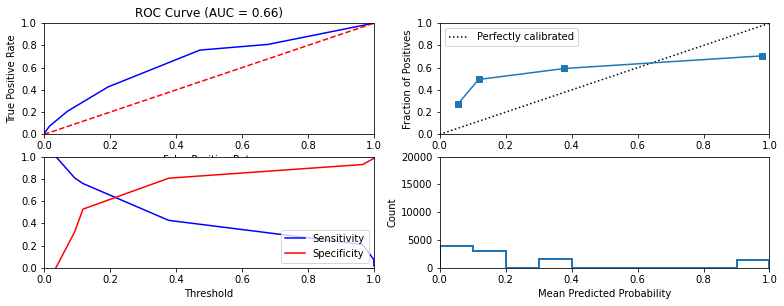


Similarity to LC grade ranking:  0.8150196202204226
Brier score: 0.30318658444067476


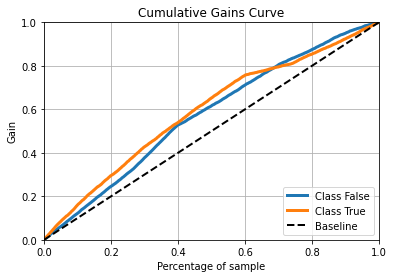

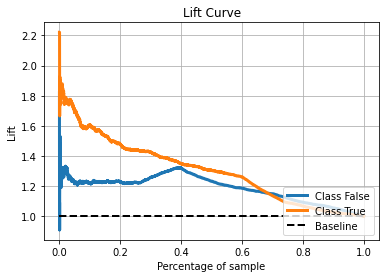

  Decile  Decile Lift
9      1     1.590051
8      2     1.490118
4      6     1.370198
5      5     1.308017
6      4     1.253831
7      3     1.261011
3      7     1.133530
0     10     1.084832
1      9     1.040294
2      8     1.000000
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.60424]


In [ ]:
data_dict = prepare_data(feature_subset=['grade'])
grade_only_gnb = GaussianNB()
grade_only_gnb = fit_classification(grade_only_gnb, data_dict,
                model_name = "Grade Only Gaussian Naive Bayes", output_confusion_matrix=True)

#### Decision Trees (Grade only)

  Model: Decision tree
Fit time: 0.32 seconds
Optimal parameters:
{'min_samples_leaf': 500}

Accuracy-maximizing threshold was: 0.5897929706307173
Accuracy:  0.5982
              precision    recall  f1-score   support

  No default     0.5844    0.9316    0.7182      5497
     Default     0.6960    0.1912    0.3000      4503

    accuracy                         0.5982     10000
   macro avg     0.6402    0.5614    0.5091     10000
weighted avg     0.6347    0.5982    0.5299     10000

Confusion matrix : 
 [[ 861 3642]
 [ 376 5121]]
Expected Value: 314.86


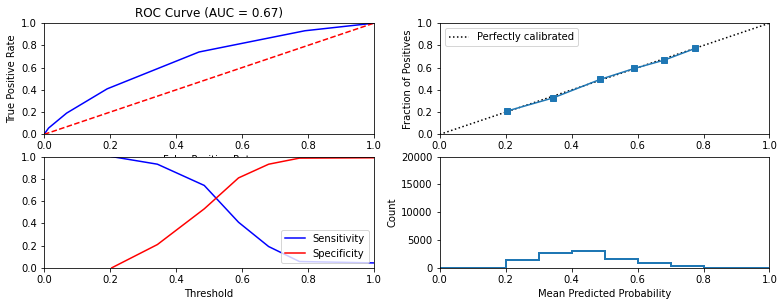


Similarity to LC grade ranking:  0.9600800688907511
Brier score: 0.2236816132673189


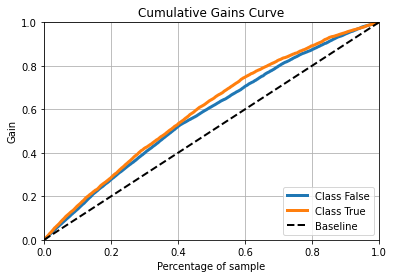

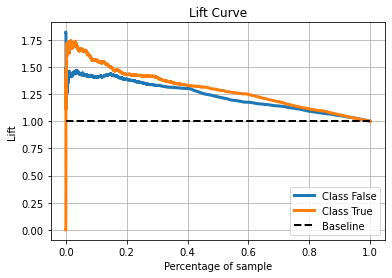

  Decile  Decile Lift
9      1     1.561181
8      2     1.453475
5      5     1.342068
6      4     1.269709
7      3     1.273817
2      8     1.186986
3      7     1.118937
4      6     1.116755
0     10     1.044489
1      9     1.000000
Were parameters on edge? : True
Score variations around CV search grid : 2.6141712250349847
[0.62888 0.6172  0.61244 0.61244 0.61244 0.61244 0.61244 0.61244 0.61244]
314.86199999999997


In [ ]:

data_dict = prepare_data(feature_subset=['grade'])
decision_tree = DecisionTreeClassifier()
cv_parameters = {'min_samples_leaf':[500,600,700,800,900,1000, 1100, 1200, 1300]}

decision_tree, c_matrix = fit_classification(decision_tree, data_dict,
                          cv_parameters = cv_parameters, model_name = "Decision tree", output_confusion_matrix=True)

expectedValue = np.sum(c_matrix * confusion_cost)
print(expectedValue)

#### Random Forest (Grade Only)

  Model: Random forest
Fit time: 18.71 seconds
Optimal parameters:
{'min_samples_leaf': 500}

Accuracy-maximizing threshold was: 0.4190458701982919
Accuracy:  0.607
              precision    recall  f1-score   support

  No default     0.6776    0.5438    0.6034      5497
     Default     0.5513    0.6842    0.6106      4503

    accuracy                         0.6070     10000
   macro avg     0.6144    0.6140    0.6070     10000
weighted avg     0.6207    0.6070    0.6066     10000



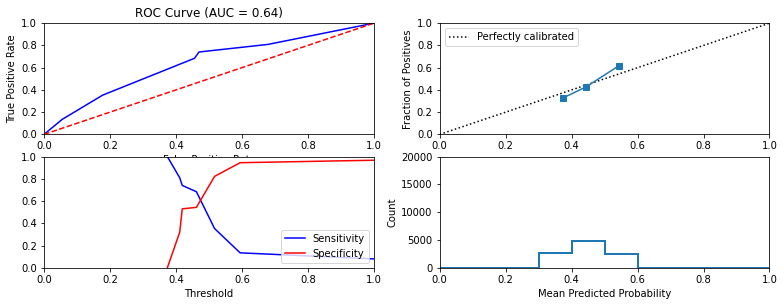


Similarity to LC grade ranking:  0.7010450930843801
Brier score: 0.23586292581112334


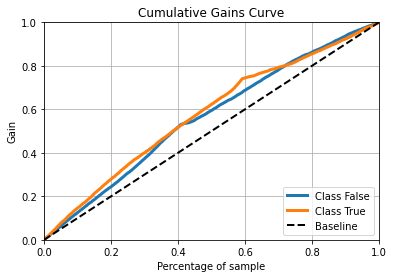

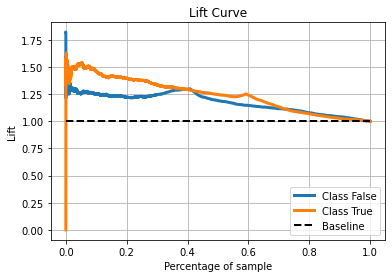

  Decile  Decile Lift
8      2     1.292472
9      1     1.390184
5      5     1.296913
6      4     1.235288
7      3     1.229403
3      7     1.098897
4      6     1.127820
0     10     1.079836
1      9     1.035853
2      8     1.000000
Were parameters on edge? : True
Score variations around CV search grid : 5.590751747109911
[0.61244 0.61244 0.61244 0.61244 0.61244 0.61244 0.61244 0.59644 0.5782 ]


In [ ]:
data_dict = prepare_data(feature_subset=['grade'])
random_forest = RandomForestClassifier()
cv_parameters = {'min_samples_leaf':[500,600,700,800,900,1000, 1100, 1200, 1300]}

random_forest = fit_classification(random_forest, data_dict,
                          cv_parameters = cv_parameters, model_name = "Random forest")

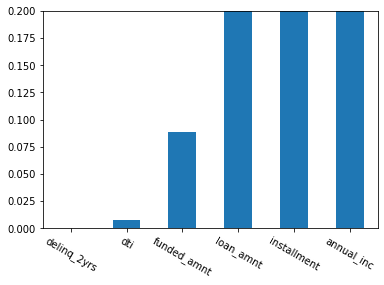

In [ ]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

#### Bagged Trees (Grade Only)

  Model: Bagged trees
Fit time: 24.5 seconds
Optimal parameters:
{'min_samples_leaf': 500}

Accuracy-maximizing threshold was: 0.5893844403973759
Accuracy:  0.5802
              precision    recall  f1-score   support

  No default     0.5714    0.9452    0.7123      5497
     Default     0.6681    0.1346    0.2240      4503

    accuracy                         0.5802     10000
   macro avg     0.6198    0.5399    0.4681     10000
weighted avg     0.6150    0.5802    0.4924     10000



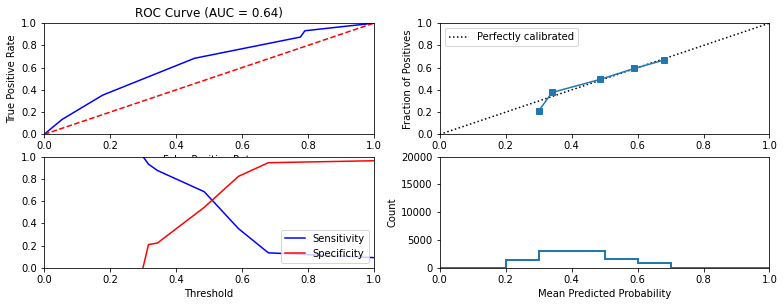


Similarity to LC grade ranking:  0.8340025469891951
Brier score: 0.23169464378913981


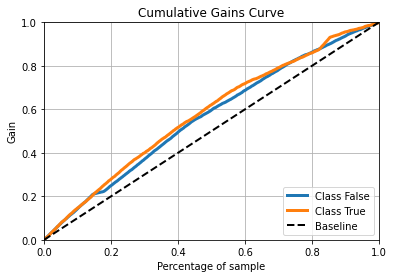

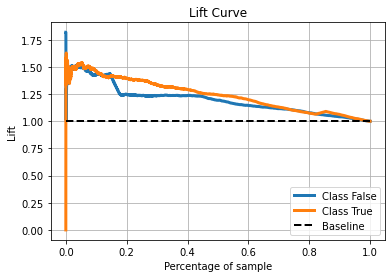

  Decile  Decile Lift
8      2     1.292472
9      1     1.390184
5      5     1.296913
6      4     1.235288
7      3     1.229403
2      8     1.149234
3      7     1.084674
4      6     1.074839
0     10     1.007230
1      9     1.000000
Were parameters on edge? : True
Score variations around CV search grid : 5.590751747109911
[0.61244 0.61244 0.61244 0.61244 0.61244 0.61244 0.61244 0.59644 0.5782 ]


In [ ]:
data_dict = prepare_data(feature_subset=['grade'])
random_forest = RandomForestClassifier(max_features = 1.0)
cv_parameters = {'min_samples_leaf':[500,600,700,800,900,1000, 1100, 1200, 1300]}

random_forest = fit_classification(random_forest, data_dict,
                          cv_parameters = cv_parameters, model_name = "Bagged trees")

#### MLP (Grade Only)

  Model: Grade only MLP
Fit time: 27.56 seconds
Optimal parameters:
{'activation': 'identity'}

Accuracy-maximizing threshold was: 0.5665379775713157
Accuracy:  0.6289
              precision    recall  f1-score   support

  No default     0.6257    0.8086    0.7055      5497
     Default     0.6367    0.4095    0.4984      4503

    accuracy                         0.6289     10000
   macro avg     0.6312    0.6091    0.6020     10000
weighted avg     0.6307    0.6289    0.6123     10000

Confusion matrix : 
 [[1844 2659]
 [1052 4445]]
Expected Value: 331.31


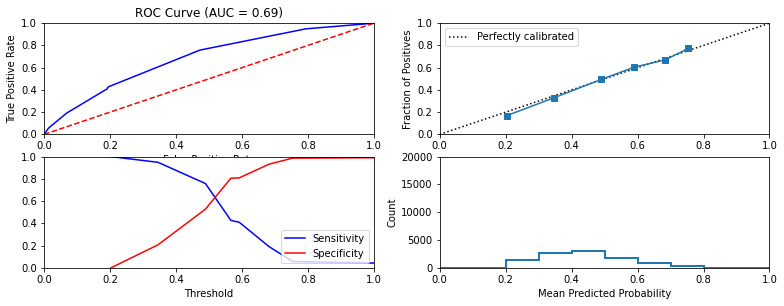


Similarity to LC grade ranking:  0.9869557936854396
Brier score: 0.22067658067876436


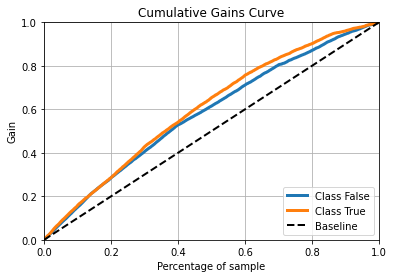

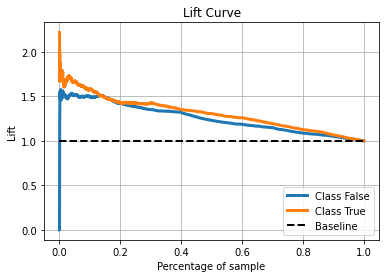

  Decile  Decile Lift
9      1     1.561181
8      2     1.453475
4      6     1.345769
5      5     1.289696
6      4     1.239174
7      3     1.261011
2      8     1.188414
3      7     1.128137
0     10     1.043749
1      9     1.000000
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.62888]


In [ ]:
data_dict = prepare_data(feature_subset=['grade'])
grade_only_MLP = MLPClassifier(random_state=1, max_iter=50,  
                         batch_size=100, hidden_layer_sizes=(100,), solver = 'sgd')

#cv_parameters = {'activation':['identity','tanh','relu','logistic']}
cv_parameters = {'activation':['identity']}
grade_only_MLP, c_matrix = fit_classification(grade_only_MLP,data_dict,
                                         cv_parameters = cv_parameters,
                                         model_name = 'Grade only MLP',
                                         output_confusion_matrix = True)

In [ ]:
### Return a cost matrix
TP_Gain = 0.03 #return from safe investment
FN_Cost = -0.05
FP_Cost = 0 
TN_Gain = 0.092
confusion_cost = np.array([[TP_Gain,FN_Cost],[FP_Cost,TN_Gain]])
print(confusion_cost)
expectedValue = np.sum(c_matrix * confusion_cost)
print(expectedValue)

[[ 0.03  -0.05 ]
 [ 0.     0.092]]
331.30999999999995


### Interest Rate Only

#### $l_1$ penalized logistic regression (Interest only)

  Model: Interest only Logistic l1
Fit time: 3.4 seconds
Optimal parameters:
{'C': 1.0}

Accuracy-maximizing threshold was: 0.45438185038248347
Accuracy:  0.6382
              precision    recall  f1-score   support

  No default     0.6632    0.6944    0.6785      5497
     Default     0.6042    0.5696    0.5864      4503

    accuracy                         0.6382     10000
   macro avg     0.6337    0.6320    0.6324     10000
weighted avg     0.6367    0.6382    0.6370     10000



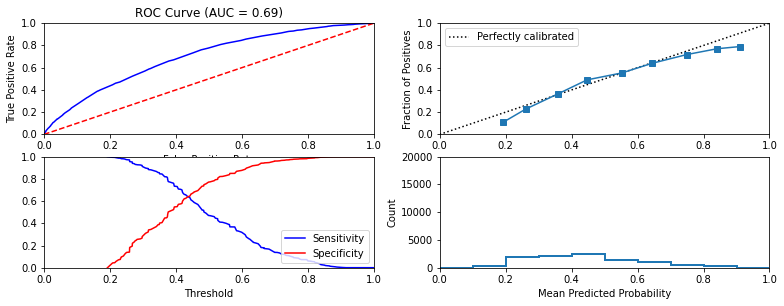


Similarity to LC grade ranking:  0.8826478717984018
Brier score: 0.22025318190860962


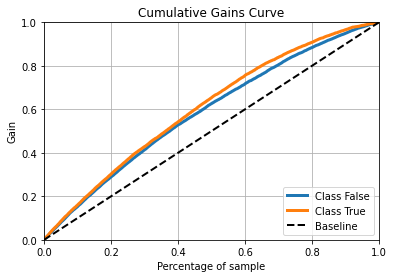

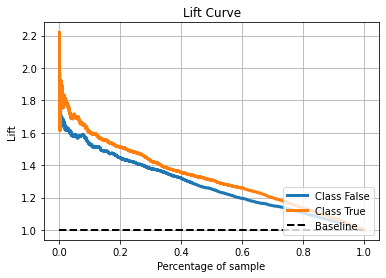

  Decile  Decile Lift
9      1     1.601155
8      2     1.513435
7      3     1.426456
6      4     1.355208
5      5     1.307129
4      6     1.259161
3      7     1.199201
2      8     1.133966
1      9     1.072618
0     10     1.000000
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.63868 0.63868 0.63868 0.63868 0.63868 0.63868 0.63868 0.63868 0.63868
 0.63868 0.63868 0.63868 0.63868 0.63868 0.63868 0.63868 0.63868 0.63868
 0.63868 0.63868]


In [ ]:
data_dict = prepare_data(feature_subset=['int_rate'])
interest_only_logistic_l1 = LogisticRegression(penalty = 'l1', solver='liblinear')
cv_parameters = {"C":np.logspace(0, 50, num = 20)}

interest_only_logistic_l1 = fit_classification(interest_only_logistic_l1, data_dict,
                        cv_parameters = cv_parameters, model_name = "Interest only Logistic l1")

#### $l_2$ penalized logistic regression (Interest only)

  Model: Interest only logistic l2
Fit time: 0.21 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.45434343621149886
Accuracy:  0.6382
              precision    recall  f1-score   support

  No default     0.6632    0.6944    0.6785      5497
     Default     0.6042    0.5696    0.5864      4503

    accuracy                         0.6382     10000
   macro avg     0.6337    0.6320    0.6324     10000
weighted avg     0.6367    0.6382    0.6370     10000



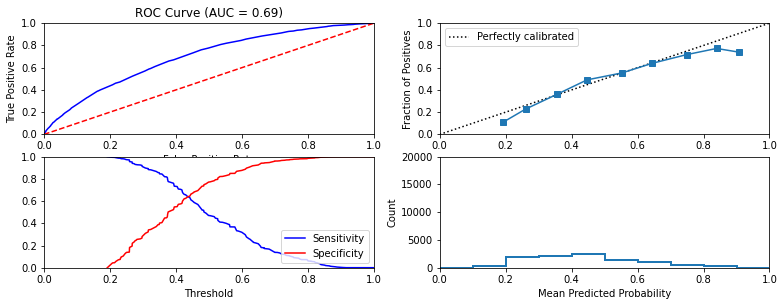


Similarity to LC grade ranking:  0.8826478717984018
Brier score: 0.22025165033821853


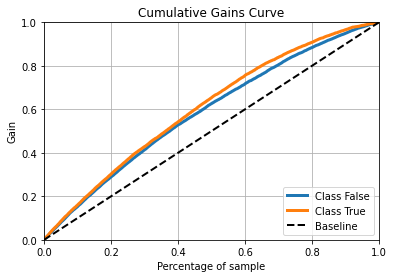

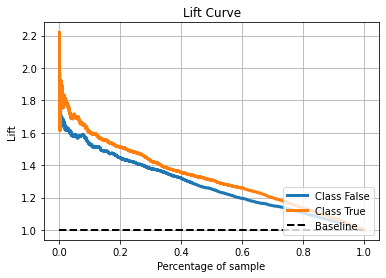

  Decile  Decile Lift
9      1     1.601155
8      2     1.513435
7      3     1.426456
6      4     1.355208
5      5     1.307129
4      6     1.259161
3      7     1.199201
2      8     1.133966
1      9     1.072618
0     10     1.000000
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.63868]


In [ ]:
data_dict = prepare_data(feature_subset=['int_rate'])
interest_only_logistic = LogisticRegression(penalty = 'l2', C=np.inf, solver='lbfgs')

interest_only_logistic = fit_classification(interest_only_logistic,data_dict,
                                         model_name = 'Interest only logistic l2')

#### Naive Bayes - Interest Rate Only

  Model: Interest Only Gaussian Naive Bayes
Fit time: 0.02 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.4277514865655062
Accuracy:  0.6382
              precision    recall  f1-score   support

  No default     0.6632    0.6944    0.6785      5497
     Default     0.6042    0.5696    0.5864      4503

    accuracy                         0.6382     10000
   macro avg     0.6337    0.6320    0.6324     10000
weighted avg     0.6367    0.6382    0.6370     10000

Confusion matrix : 
 [[2565 1938]
 [1680 3817]]
Expected Value: 331.21


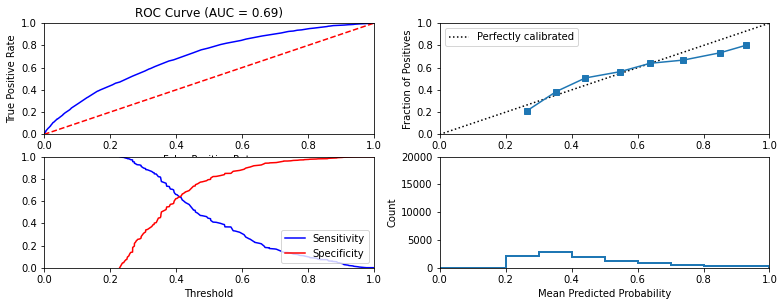


Similarity to LC grade ranking:  0.8826478717984018
Brier score: 0.22241545356351486


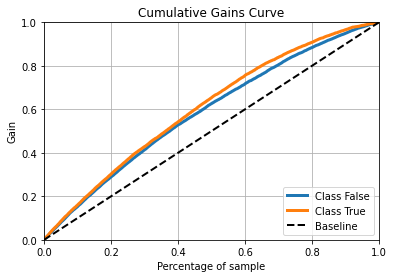

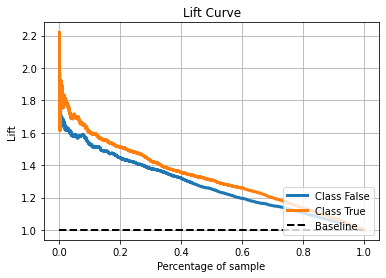

  Decile  Decile Lift
9      1     1.601155
8      2     1.513435
7      3     1.426456
6      4     1.355208
5      5     1.307129
4      6     1.259161
3      7     1.199201
2      8     1.133966
1      9     1.072618
0     10     1.000000
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.6346]


In [ ]:
data_dict = prepare_data(feature_subset=['int_rate'])
interest_only_gnb = GaussianNB()
interest_only_gnb = fit_classification(interest_only_gnb, data_dict,
                model_name = "Interest Only Gaussian Naive Bayes", output_confusion_matrix=True)

#### Random Forest (Interest Only)

  Model: Interest Only Random forest
Fit time: 27.02 seconds
Optimal parameters:
{'min_samples_leaf': 1300}

Accuracy-maximizing threshold was: 0.5028850821976406
Accuracy:  0.6382
              precision    recall  f1-score   support

  No default     0.6632    0.6944    0.6785      5497
     Default     0.6042    0.5696    0.5864      4503

    accuracy                         0.6382     10000
   macro avg     0.6337    0.6320    0.6324     10000
weighted avg     0.6367    0.6382    0.6370     10000



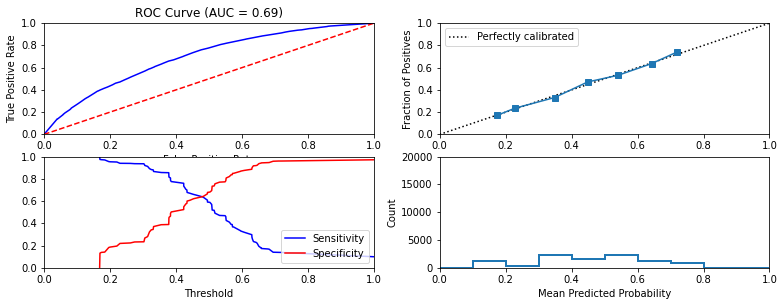


Similarity to LC grade ranking:  0.8863257096344839
Brier score: 0.21951003652238896


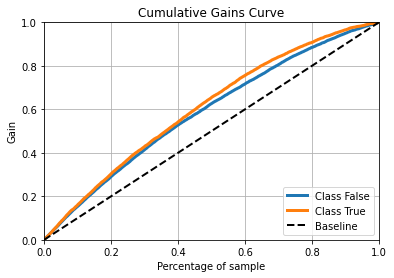

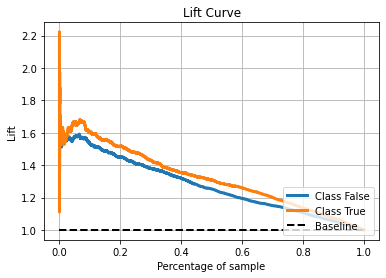

  Decile  Decile Lift
9      1     1.601155
8      2     1.513435
7      3     1.426456
6      4     1.355208
5      5     1.307129
4      6     1.259531
3      7     1.199201
2      8     1.134244
1      9     1.072618
0     10     1.000000
Were parameters on edge? : True
Score variations around CV search grid : 0.17459624618070865
[0.64144 0.64144 0.64036 0.64144 0.64144 0.64144 0.64036 0.6404  0.64148]


In [ ]:
data_dict = prepare_data(feature_subset=['int_rate'])
random_forest = RandomForestClassifier()
cv_parameters = {'min_samples_leaf':[500,600,700,800,900,1000, 1100, 1200, 1300]}

random_forest = fit_classification(random_forest, data_dict,
                          cv_parameters = cv_parameters, model_name = "Interest Only Random forest")

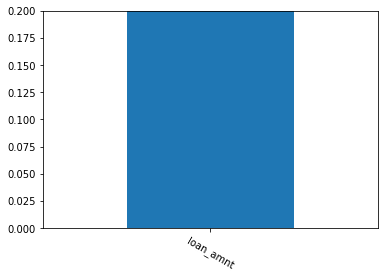

In [ ]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

#### Bagged Trees (Interest Only)

  Model: Interest Rate Bagged trees
Fit time: 27.35 seconds
Optimal parameters:
{'min_samples_leaf': 1300}

Accuracy-maximizing threshold was: 0.5028850821976406
Accuracy:  0.6382
              precision    recall  f1-score   support

  No default     0.6632    0.6944    0.6785      5497
     Default     0.6042    0.5696    0.5864      4503

    accuracy                         0.6382     10000
   macro avg     0.6337    0.6320    0.6324     10000
weighted avg     0.6367    0.6382    0.6370     10000



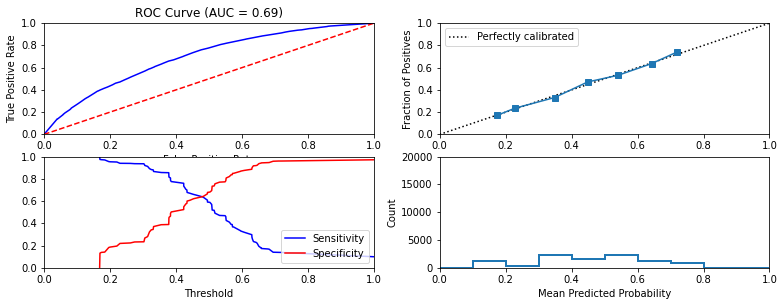


Similarity to LC grade ranking:  0.8863257096344839
Brier score: 0.21951003652238896


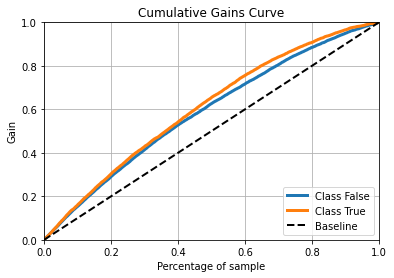

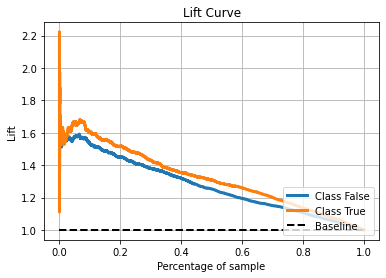

  Decile  Decile Lift
9      1     1.601155
8      2     1.513435
7      3     1.426456
6      4     1.355208
5      5     1.307129
4      6     1.259531
3      7     1.199201
2      8     1.134244
1      9     1.072618
0     10     1.000000
Were parameters on edge? : True
Score variations around CV search grid : 0.17459624618070865
[0.64144 0.64144 0.64036 0.64144 0.64144 0.64144 0.64036 0.6404  0.64148]


In [ ]:
data_dict = prepare_data(feature_subset=['int_rate'])
random_forest = RandomForestClassifier(max_features = 1.0)
cv_parameters = {'min_samples_leaf':[500,600,700,800,900,1000, 1100, 1200, 1300]}

random_forest = fit_classification(random_forest, data_dict,
                          cv_parameters = cv_parameters, model_name = "Interest Rate Bagged trees")

#### MLP (Interest Only)

  Model: Interest rate only MLP
Fit time: 22.0 seconds
Optimal parameters:
{'activation': 'identity'}

Accuracy-maximizing threshold was: 0.4568972878747587
Accuracy:  0.6382
              precision    recall  f1-score   support

  No default     0.6632    0.6944    0.6785      5497
     Default     0.6042    0.5696    0.5864      4503

    accuracy                         0.6382     10000
   macro avg     0.6337    0.6320    0.6324     10000
weighted avg     0.6367    0.6382    0.6370     10000

Confusion matrix : 
 [[2565 1938]
 [1680 3817]]
Expected Value: 331.21


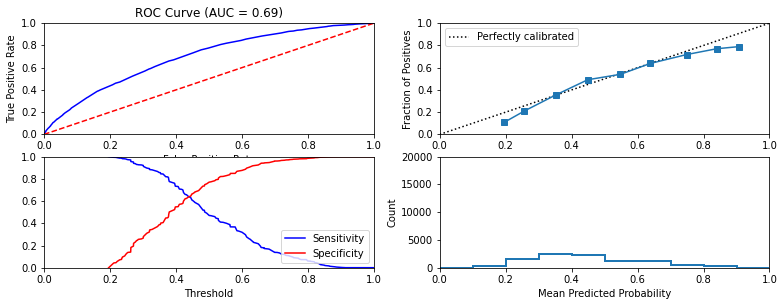


Similarity to LC grade ranking:  0.8826478717984018
Brier score: 0.22025613240919498


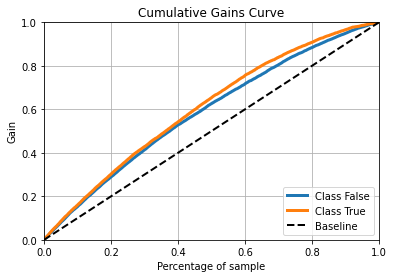

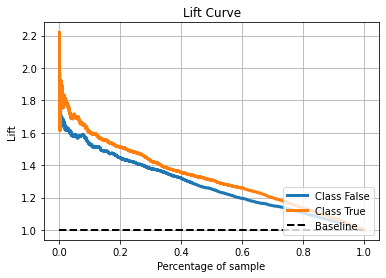

  Decile  Decile Lift
9      1     1.601155
8      2     1.513435
7      3     1.426456
6      4     1.355208
5      5     1.307129
4      6     1.259161
3      7     1.199201
2      8     1.133966
1      9     1.072618
0     10     1.000000
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.63876]


In [ ]:
data_dict = prepare_data(feature_subset=['int_rate'])
grade_only_MLP = MLPClassifier(random_state=1, max_iter=50,  
                         batch_size=100, hidden_layer_sizes=(100,), solver = 'sgd')

#cv_parameters = {'solver': ['sgd'], 'activation':['identity','tanh','relu','logistic']}
cv_parameters = {'activation':['identity']}
grade_only_MLP, c_matrix = fit_classification(grade_only_MLP,data_dict,
                                         cv_parameters = cv_parameters,
                                         model_name = 'Interest rate only MLP',
                                        output_confusion_matrix = True)

In [ ]:
### Return a cost matrix
TP_Gain = 0.03 #return from safe investment
FN_Cost = -0.05
FP_Cost = 0 
TN_Gain = 0.092
confusion_cost = np.array([[TP_Gain,FN_Cost],[FP_Cost,TN_Gain]])
print(confusion_cost)
expectedValue = np.sum(c_matrix * confusion_cost)
print(expectedValue)

[[ 0.03  -0.05 ]
 [ 0.     0.092]]
331.214


## Step 4- Test models without grade or interest rate

In [ ]:
final_features = [i for i in discrete_features + continuous_features if i not in ["grade", "int_rate", "installment"]]
data_dict = prepare_data(feature_subset = final_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in final_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

In [ ]:
final_features

['purpose',
 'term',
 'verification_status',
 'emp_length',
 'home_ownership',
 'loan_amnt',
 'funded_amnt',
 'annual_inc',
 'dti',
 'revol_bal',
 'delinq_2yrs',
 'open_acc',
 'pub_rec',
 'fico_range_high',
 'fico_range_low',
 'revol_util',
 'cr_hist']

### Ridge Classifier

In [ ]:
ridge_classifier = RidgeClassifier()
cv_parameters = {"alpha":np.logspace(-4, 4, num = 10)}

ridge_classifier = fit_classification(ridge_classifier, data_dict,
                             cv_parameters = cv_parameters, model_name = "Ridge Classifier")

  Model: Ridge Classifier
Fit time: 1.81 seconds
Optimal parameters:
{'alpha': 21.54434690031882}

Accuracy:  0.6376
              precision    recall  f1-score   support

  No default     0.6512    0.7337    0.6900      5497
     Default     0.6154    0.5203    0.5639      4503

    accuracy                         0.6376     10000
   macro avg     0.6333    0.6270    0.6269     10000
weighted avg     0.6351    0.6376    0.6332     10000


Similarity to LC grade ranking:  0.49408678001733486


### Naive Bayes

  Model: Gaussian Naive Bayes
Fit time: 0.18 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.4092052637908915
Accuracy:  0.6164
              precision    recall  f1-score   support

  No default     0.6404    0.6893    0.6639      5497
     Default     0.5817    0.5274    0.5532      4503

    accuracy                         0.6164     10000
   macro avg     0.6110    0.6084    0.6086     10000
weighted avg     0.6139    0.6164    0.6141     10000

Confusion matrix : 
 [[2375 2128]
 [1708 3789]]
Expected Value: 313.44


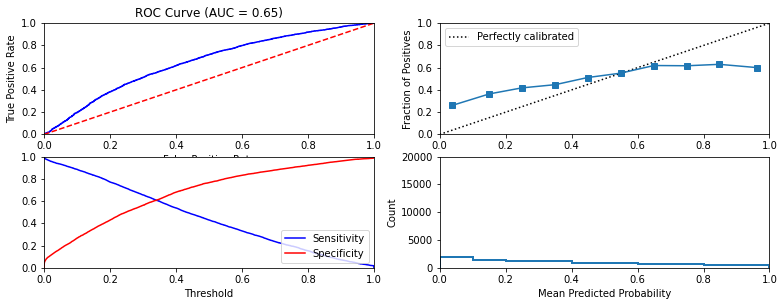


Similarity to LC grade ranking:  0.3892381519277021
Brier score: 0.26366066882022426


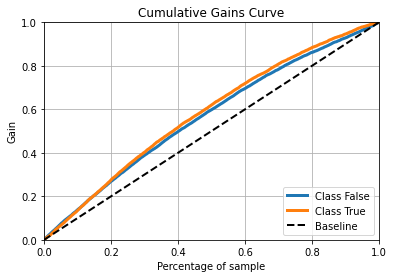

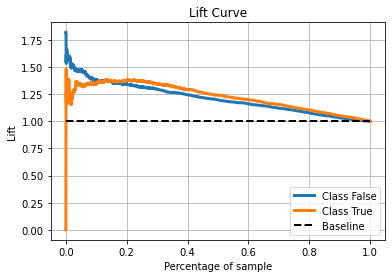

  Decile  Decile Lift
9      1     1.352432
8      2     1.376860
7      3     1.342068
6      4     1.291361
5      5     1.239618
4      6     1.198090
3      7     1.154468
2      8     1.104541
1      9     1.051645
0     10     1.000000
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.61212]


In [ ]:
gnb = GaussianNB()
gnb = fit_classification(gnb, data_dict,
                model_name = "Gaussian Naive Bayes", output_confusion_matrix=True)


### $l_1$ penalized logistic regression
(Takes a couple of minutes)

  Model: l1 Penalized Logistic Regression
Fit time: 232.27 seconds
Optimal parameters:
{'C': 1.0}

Accuracy-maximizing threshold was: 0.4983528455683573
Accuracy:  0.6369
              precision    recall  f1-score   support

  No default     0.6531    0.7240    0.6867      5497
     Default     0.6116    0.5305    0.5682      4503

    accuracy                         0.6369     10000
   macro avg     0.6324    0.6273    0.6275     10000
weighted avg     0.6344    0.6369    0.6334     10000

Confusion matrix : 
 [[2389 2114]
 [1517 3980]]
Expected Value: 332.13


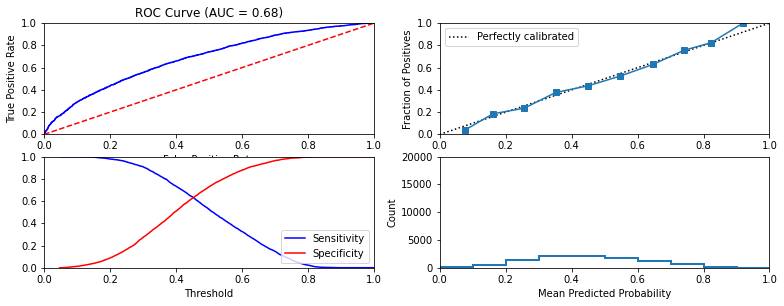


Similarity to LC grade ranking:  0.49596872211789356
Brier score: 0.221671886244618


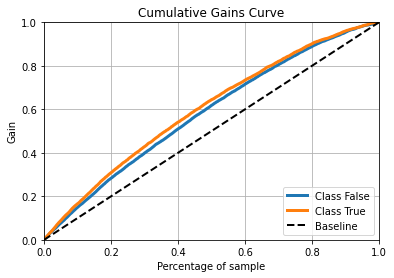

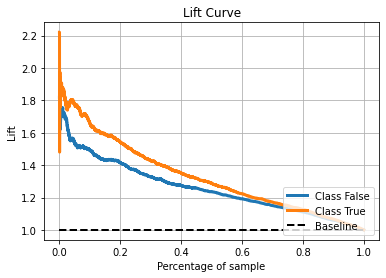

  Decile  Decile Lift
9      1     1.656673
8      2     1.542305
7      3     1.427937
6      4     1.351321
5      5     1.288918
4      6     1.223629
3      7     1.172869
2      8     1.127026
1      9     1.066943
0     10     1.000000
Were parameters on edge? : True
Score variations around CV search grid : 0.05633802816903568
[0.639   0.63864 0.63876 0.63872 0.63868 0.63876 0.63872 0.63868 0.63868
 0.63872]


In [ ]:
l1_logistic = LogisticRegression(penalty = 'l1',solver='liblinear')
cv_parameters = {"C":np.logspace(0, 6, num = 10)}

l1_logistic, coefs = fit_classification(l1_logistic, data_dict,
                        cv_parameters = cv_parameters, model_name = "l1 Penalized Logistic Regression", output_confusion_matrix=True)

### $l_2$ penalized logistic regression

  Model: l2 Penalized Logistic Regression
Fit time: 15.21 seconds
Optimal parameters:
{'C': 0.3593813663804626}

Accuracy-maximizing threshold was: 0.4910978327452352
Accuracy:  0.6356
              precision    recall  f1-score   support

  No default     0.6555    0.7104    0.6819      5497
     Default     0.6062    0.5443    0.5736      4503

    accuracy                         0.6356     10000
   macro avg     0.6309    0.6273    0.6277     10000
weighted avg     0.6333    0.6356    0.6331     10000

Confusion matrix : 
 [[2451 2052]
 [1592 3905]]
Expected Value: 330.19


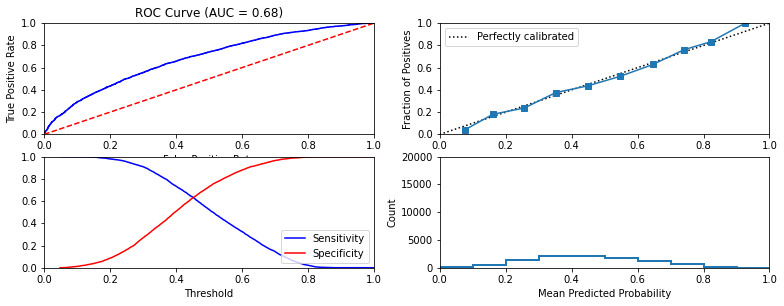


Similarity to LC grade ranking:  0.4958361620786787
Brier score: 0.22167699539529787


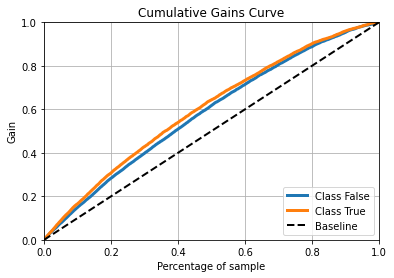

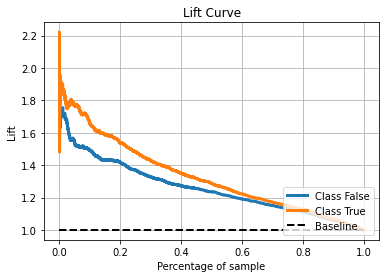

  Decile  Decile Lift
9      1     1.654453
8      2     1.536753
7      3     1.428677
6      4     1.349101
5      5     1.287586
4      6     1.221778
3      7     1.170648
2      8     1.127026
1      9     1.066450
0     10     1.000000
Were parameters on edge? : False
Score variations around CV search grid : 14.259803614985312
[0.54836 0.61864 0.63464 0.63896 0.63956 0.6384  0.6386  0.63876 0.63864
 0.6388 ]


In [ ]:
l2_logistic = LogisticRegression(penalty = 'l2')
cv_parameters = {"C":np.logspace(-4, 4, num = 10)}

l2_logistic, costs = fit_classification(l2_logistic, data_dict,
                        cv_parameters = cv_parameters, model_name = "l2 Penalized Logistic Regression", output_confusion_matrix=True, predProb=True)

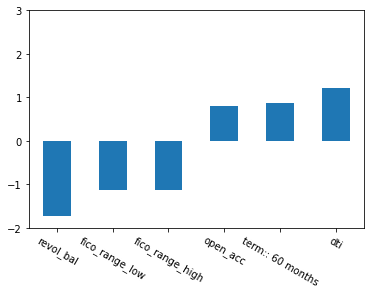

In [ ]:
## plot top 3 features with the most positive (and negative) weights
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-2,3))
p1.set_xticklabels(xticks)
plt.show()

In [ ]:
np.exp(l2_logistic['model'].coef_)
logisticCols = selected_features
logisticStd = np.std(data_dict['X_test'], axis=0)
logisticResultDf = pd.DataFrame()
logisticResultDf['Column'] = logisticCols
logisticResultDf['Coef'] = (l2_logistic['model'].coef_).reshape(-1,1)
logisticResultDf['StdDev'] = logisticStd

logisticResultDf['OddsChange'] = logisticResultDf.apply(lambda x: np.exp(x['Coef'] * x['StdDev']), axis=1)

logisticResultDf.sort_values(by='OddsChange').style.format({"OddsChange":"{:.2%}"})

,Column,Coef,StdDev,OddsChange
9,fico_range_low,-1.128330,0.158094,83.66%
8,fico_range_high,-1.122429,0.157244,83.82%
4,revol_bal,-1.728170,0.087397,85.98%
2,annual_inc,-1.067484,0.109633,88.96%
12,purpose::credit_card,-0.174138,0.411859,93.08%
41,home_ownership::MORTGAGE,-0.142611,0.498781,93.13%
11,cr_hist,-0.560153,0.124168,93.28%
36,emp_length::7 years,-0.017034,0.196194,99.67%
13,purpose::debt_consolidation,-0.005122,0.491161,99.75%
5,delinq_2yrs,-0.026132,0.056860,99.85%


### Decision tree

  Model: Decision tree
Fit time: 4.32 seconds
Optimal parameters:
{'min_samples_leaf': 800}

Accuracy-maximizing threshold was: 0.502106149957877
Accuracy:  0.6242
              precision    recall  f1-score   support

  No default     0.6315    0.7595    0.6896      5497
     Default     0.6099    0.4590    0.5238      4503

    accuracy                         0.6242     10000
   macro avg     0.6207    0.6093    0.6067     10000
weighted avg     0.6218    0.6242    0.6150     10000

Confusion matrix : 
 [[2067 2436]
 [1322 4175]]
Expected Value: 324.31


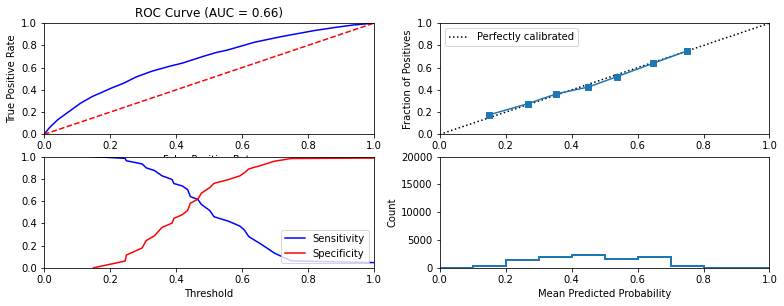


Similarity to LC grade ranking:  0.4231750241675093
Brier score: 0.22757460566511473


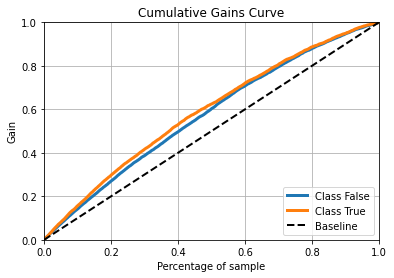

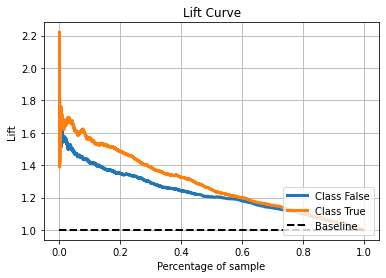

  Decile  Decile Lift
9      1     1.563402
8      2     1.491228
7      3     1.387964
6      4     1.328559
5      5     1.249833
4      6     1.198090
3      7     1.152248
2      8     1.107595
1      9     1.056580
0     10     1.000000
Were parameters on edge? : False
Score variations around CV search grid : 0.698762741201364
[0.62368 0.62324 0.62324 0.62396 0.62144 0.62092 0.62056 0.6196  0.62076]
324.30999999999995


In [ ]:
decision_tree = DecisionTreeClassifier()
cv_parameters = {'min_samples_leaf':[500,600,700,800,900,1000, 1100, 1200, 1300]}

decision_tree, c_matrix = fit_classification(decision_tree, data_dict,
                          cv_parameters = cv_parameters, model_name = "Decision tree", output_confusion_matrix=True)

expectedValue = np.sum(c_matrix * confusion_cost)
print(expectedValue)

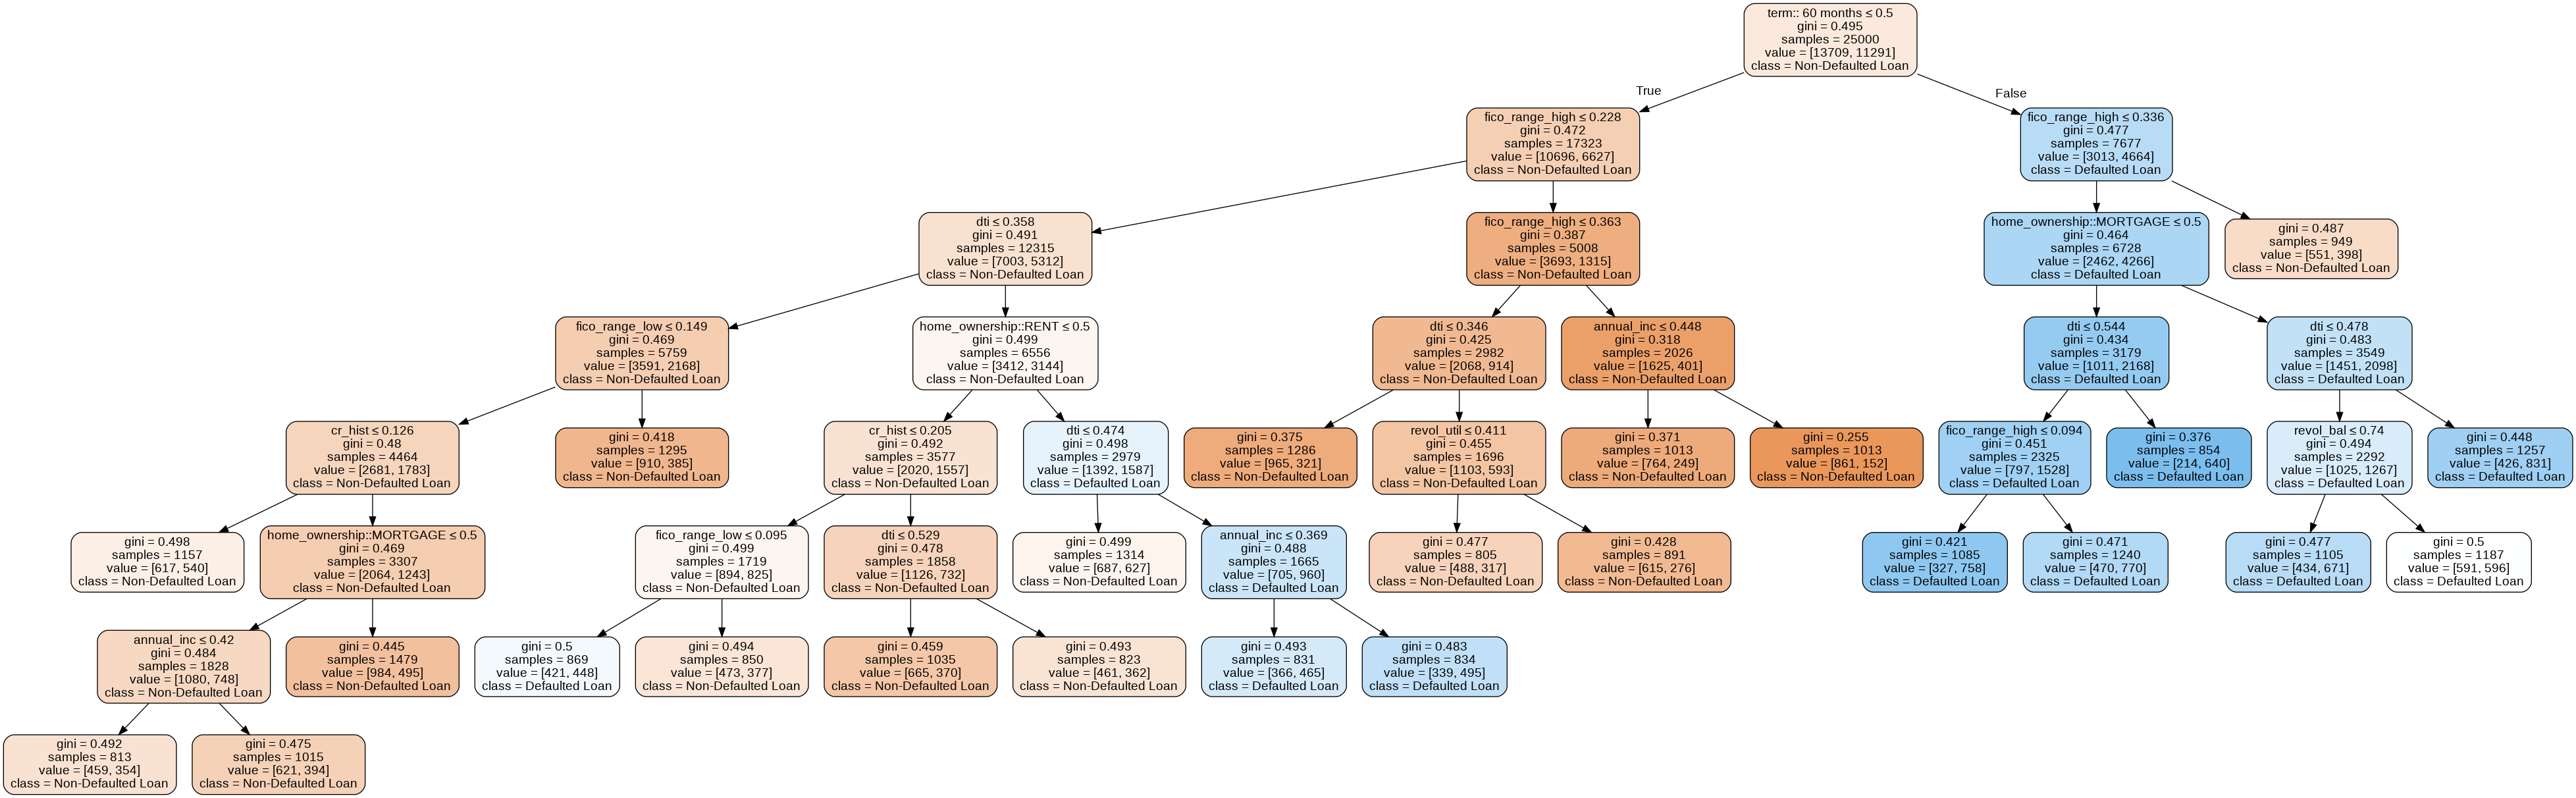

In [ ]:
# Visualize the decision tree
# Zooming-in is allowed by double click
from sklearn.externals.six import StringIO
import graphviz

target_names = ['Non-Defaulted Loan','Defaulted Loan']
dot_data = StringIO()
export_graphviz(decision_tree['model'], out_file=dot_data,
                feature_names=selected_features,filled=True, rounded=True, class_names=target_names,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

### Random Forest

  Model: Random forest
Fit time: 48.82 seconds
Optimal parameters:
{'min_samples_leaf': 500}

Accuracy-maximizing threshold was: 0.4737748124131136
Accuracy:  0.6316
              precision    recall  f1-score   support

  No default     0.6487    0.7193    0.6822      5497
     Default     0.6049    0.5245    0.5618      4503

    accuracy                         0.6316     10000
   macro avg     0.6268    0.6219    0.6220     10000
weighted avg     0.6290    0.6316    0.6280     10000

Confusion matrix : 
 [[2362 2141]
 [1543 3954]]
Expected Value: 327.58


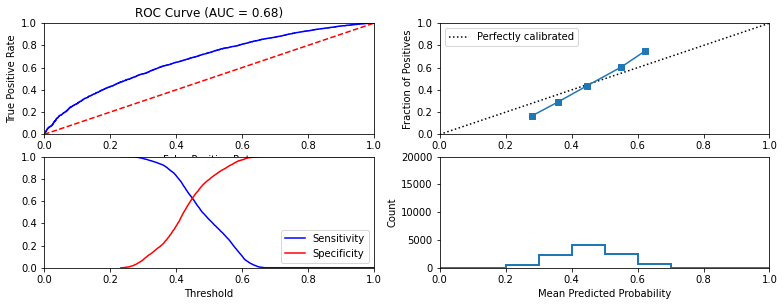


Similarity to LC grade ranking:  0.4554558304671575
Brier score: 0.22781367541326422


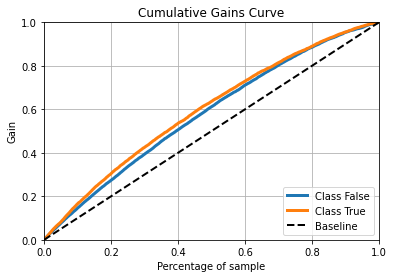

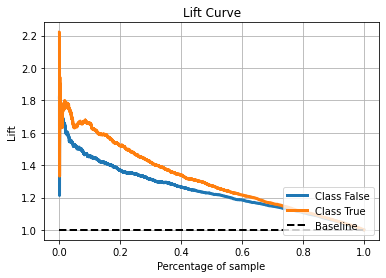

  Decile  Decile Lift
9      1     1.656673
8      2     1.521208
7      3     1.417573
6      4     1.339107
5      5     1.272929
4      6     1.215856
3      7     1.163986
2      8     1.112036
1      9     1.062255
0     10     1.000000
Were parameters on edge? : True
Score variations around CV search grid : 1.2625940568805059
[0.62728 0.62532 0.62468 0.6234  0.62252 0.62068 0.61996 0.6196  0.61936]


In [ ]:
random_forest = RandomForestClassifier()
cv_parameters = {'min_samples_leaf':[500,600,700,800,900,1000, 1100, 1200, 1300]}

random_forest, conf = fit_classification(random_forest, data_dict,
                          cv_parameters = cv_parameters, model_name = "Random forest", output_confusion_matrix=True)

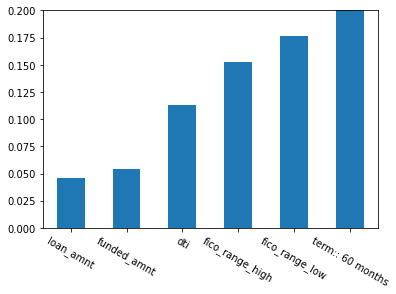

In [ ]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

### Bagged Trees

  Model: Bagged trees
Fit time: 227.59 seconds
Optimal parameters:
{'min_samples_leaf': 500}

Accuracy-maximizing threshold was: 0.46373978987612113
Accuracy:  0.6265
              precision    recall  f1-score   support

  No default     0.6567    0.6716    0.6641      5497
     Default     0.5877    0.5714    0.5794      4503

    accuracy                         0.6265     10000
   macro avg     0.6222    0.6215    0.6218     10000
weighted avg     0.6256    0.6265    0.6260     10000

Confusion matrix : 
 [[2573 1930]
 [1805 3692]]
Expected Value: 320.35


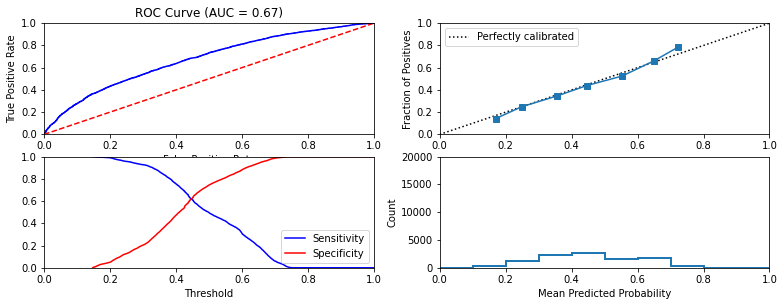


Similarity to LC grade ranking:  0.4491226377375594
Brier score: 0.2246386537084253


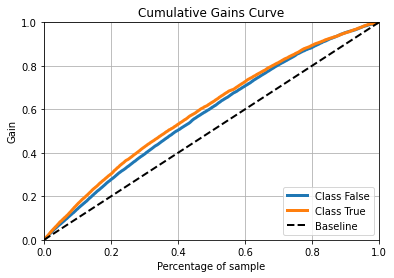

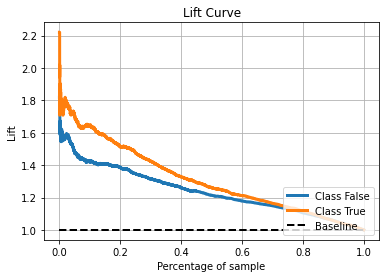

  Decile  Decile Lift
9      1     1.641128
8      2     1.513435
7      3     1.423495
6      4     1.326893
5      5     1.260493
4      6     1.212155
3      7     1.164303
2      8     1.117866
1      9     1.057320
0     10     1.000000
Were parameters on edge? : True
Score variations around CV search grid : 1.304210193099086
[0.6318  0.62896 0.62724 0.62572 0.62664 0.6252  0.62396 0.62432 0.62356]


In [ ]:
random_forest = RandomForestClassifier(max_features = 1.0)
cv_parameters = {'min_samples_leaf':[500,600,700,800,900,1000, 1100, 1200, 1300]}

random_forest = fit_classification(random_forest, data_dict,
                          cv_parameters = cv_parameters, model_name = "Bagged trees", output_confusion_matrix=True)

### MLP

  Model: MLP Classifier
Fit time: 67.61 seconds
Optimal parameters:
{'activation': 'tanh'}

Accuracy-maximizing threshold was: 0.48826716748228444
Accuracy:  0.6361
              precision    recall  f1-score   support

  No default     0.6553    0.7131    0.6830      5497
     Default     0.6075    0.5421    0.5729      4503

    accuracy                         0.6361     10000
   macro avg     0.6314    0.6276    0.6280     10000
weighted avg     0.6338    0.6361    0.6334     10000

Confusion matrix : 
 [[2441 2062]
 [1577 3920]]
Expected Value: 330.77


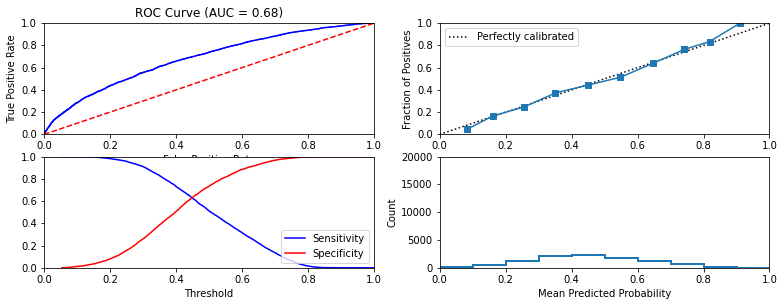


Similarity to LC grade ranking:  0.4872097293653847
Brier score: 0.2221027378294998


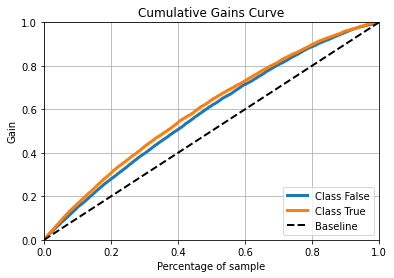

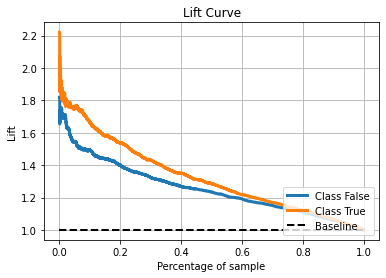

  Decile  Decile Lift
9      1     1.661115
8      2     1.537864
7      3     1.430158
6      4     1.349101
5      5     1.284921
4      6     1.218077
3      7     1.169379
2      8     1.122307
1      9     1.066943
0     10     1.000000
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.63928]


In [ ]:
mlp_classifier = MLPClassifier(random_state=1, max_iter=50,  
                      batch_size=100, hidden_layer_sizes=(100,), solver = 'sgd')

#cv_parameters = {'activation':['identity','tanh','relu','logistic']}
cv_parameters = {'activation':['tanh']}

mlp_classifier, c_matrix = fit_classification(mlp_classifier,data_dict,
                                         cv_parameters = cv_parameters,
                                         model_name = 'MLP Classifier', output_confusion_matrix = True)

In [ ]:
### Return a cost matrix
TP_Gain = 0.03 #return from safe investment
FN_Cost = -0.05
FP_Cost = 0 
TN_Gain = 0.092
confusion_cost = np.array([[TP_Gain,FN_Cost],[FP_Cost,TN_Gain]])
print(confusion_cost)
expectedValue = np.sum(c_matrix * confusion_cost)
print(expectedValue)

[[ 0.03  -0.05 ]
 [ 0.     0.092]]
330.77


## Save a "dill" of all your models for later use
Since you have ran a few complicated models that has taken considerable time, you can save these models in a dump of the whole session (not just the data) using a version of pickling called "dill" as follows.

In [ ]:
import dill
dill.dump_session('week3.pkl')

#The above command dumps a file in the current directory which you can load later as follows
# import dill
# dill.load_session('week3.pkl')
